# Alignment Exploration
This notebook explores the alignment of widefield data with the stimulus computer using the HDF5 file.
Data location: `D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random`
Output location: `D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment`


In [1]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

# Define paths
data_dir = r"D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random"
output_dir = os.path.join(data_dir, "allignment")

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")
else:
    print(f"Output directory exists: {output_dir}")

# List files in the directory
print("Files in data directory:")
try:
    files = glob.glob(os.path.join(data_dir, "*"))
    for f in files:
        print(os.path.basename(f))
except Exception as e:
    print(f"Could not list files: {e}")


Created output directory: D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment
Files in data directory:
alignment
alignment.zip
allignment
Analog_1.dat
Analog_10.dat
Analog_11.dat
Analog_2.dat
Analog_3.dat
Analog_4.dat
Analog_5.dat
Analog_6.dat
Analog_7.dat
Analog_8.dat
Analog_9.dat
data_Vtest_ledTTLrandom_OlfactometerMultipleOdorsProtocol_202601231521158.hdf5
eyecam_Vtest_ledTTL_OlfactometerMultipleOdorsProtocol_202601231521158.mp4
eyecam_Vtest_ledTTL_OlfactometerMultipleOdorsProtocol_202601231521158.txt
Frames_2_640_540_uint16_0001.dat
Frames_2_640_540_uint16_0002.dat
Frames_2_640_540_uint16_0003.dat
Frames_2_640_540_uint16_0004.dat
Frames_2_640_540_uint16_0005.dat
Frames_2_640_540_uint16_0006.dat
Frames_2_640_540_uint16_0007.dat
Frames_2_640_540_uint16_0008.dat
Frames_2_640_540_uint16_0009.dat
Frames_2_640_540_uint16_0010.dat
Frames_2_640_540_uint16_0011.dat
frameTimes_0001.mat
frameTimes_0002.mat
frameTimes_0003.mat
frameTimes_0004.mat
frameTimes_0005.mat
frameTi

In [2]:
# Function to inspect HDF5 file structure
def print_hdf5_structure(name, obj):
    print(name, type(obj))

# Find the HDF5 file
hdf5_files = glob.glob(os.path.join(data_dir, "*.hdf5")) + glob.glob(os.path.join(data_dir, "*.h5"))
if hdf5_files:
    hdf5_path = hdf5_files[0]
    print(f"Found HDF5 file: {hdf5_path}")
    
    with h5py.File(hdf5_path, 'r') as f:
        print("\nHDF5 File Structure:")
        f.visititems(print_hdf5_structure)
else:
    print("No HDF5 file found in the directory.")


Found HDF5 file: D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\data_Vtest_ledTTLrandom_OlfactometerMultipleOdorsProtocol_202601231521158.hdf5

HDF5 File Structure:
configs <class 'h5py._hl.group.Group'>
configs/experiment_config <class 'h5py._hl.group.Group'>
configs/experiment_config/ODORS <class 'h5py._hl.dataset.Dataset'>
configs/experiment_config/ODOR_EXPECTED_SIDE <class 'h5py._hl.dataset.Dataset'>
configs/experiment_config/PATTERNS <class 'h5py._hl.dataset.Dataset'>
configs/machine_config <class 'h5py._hl.group.Group'>
configs/machine_config/BACKGROUND_COLOR <class 'h5py._hl.dataset.Dataset'>
configs/machine_config/CONNECTIONS <class 'h5py._hl.group.Group'>
configs/machine_config/CONNECTIONS/stim <class 'h5py._hl.group.Group'>
configs/machine_config/CONNECTIONS/stim/ip <class 'h5py._hl.group.Group'>
configs/machine_config/DIGITAL_IO_PORT <class 'h5py._hl.dataset.Dataset'>
configs/machine_config/DISPLAY_INTENSITIES <class 'h5py._hl.dataset.Dataset'>
configs/machine_

Found sync data in: sync with shape (1289654, 14)
Found sync data in: sync_sc with shape (1289654, 14)
Loaded channel data with shape: (1289654, 14)
Normalizing all channels to 0-1...
Saved plot to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\sync_channels_normalized.png


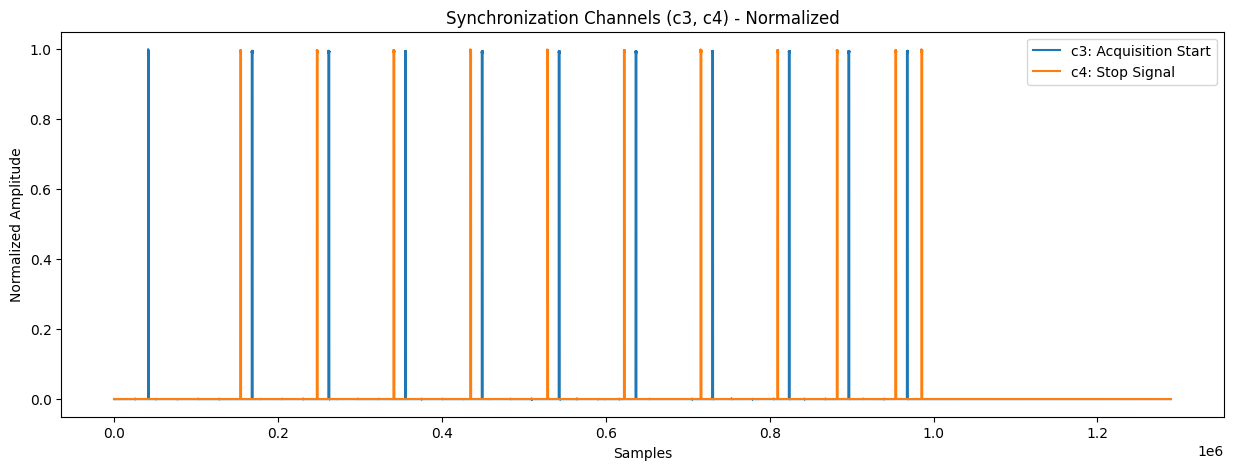

In [3]:
# Channel mapping based on user description
channel_map = {
    0: 'water_valve',
    1: 'block_timing',
    2: 'led_timing',
    3: 'acquisition_start',
    4: 'stop_signal',
    5: 'eye_camera',
    6: 'photodiode',
    7: 'rotary_z',
    8: 'rotary_a',
    9: 'rotary_b',
    10: 'lickometer',
    11: 'wrong_choice',
    12: 'mhc_timing',
    13: 'behav_cam_2'
}

def load_channels(hdf5_path):
    with h5py.File(hdf5_path, 'r') as f:
        # NOTE: Adjust the dataset path based on the structure printed above
        data = None
        def find_analog(name, obj):
            nonlocal data
            # Check for dataset with correct shape. Nicole's code mentions 'sync'
            if isinstance(obj, h5py.Dataset) and 'sync' in name:
                 data = obj[:]
                 print(f"Found sync data in: {name} with shape {obj.shape}")
            elif isinstance(obj, h5py.Dataset) and data is None and len(obj.shape) > 1 and obj.shape[1] >= 14:
                data = obj[:]
                print(f"Found potential analog data in: {name} with shape {obj.shape}")
        
        f.visititems(find_analog)
        
        if data is None:
            print("Could not find analog channel data automatically.")
            return None
            
        print(f"Loaded channel data with shape: {data.shape}")
        return data

def normalize_arr(arr):
    """Normalize array to 0-1 range."""
    min_v = np.nanmin(arr)
    max_v = np.nanmax(arr)
    if max_v - min_v == 0:
        return arr # Unchanged if as is
    return (arr - min_v) / (max_v - min_v)

if hdf5_files:
    data = load_channels(hdf5_path)
    
    if data is not None:
        # Convert to float to avoid integer truncation during normalization
        data = data.astype(float)
        
        # Normalize all channels
        print("Normalizing all channels to 0-1...")
        for i in range(data.shape[1]):
            data[:, i] = normalize_arr(data[:, i])
        
        # Plot Synchronization Channels (c3, c4)
        c3 = data[:, 3] # Acquisition Start
        c4 = data[:, 4] # Stop Signal
        
        plt.figure(figsize=(15, 5))
        plt.plot(c3, label='c3: Acquisition Start')
        plt.plot(c4, label='c4: Stop Signal')
        plt.legend()
        plt.title('Synchronization Channels (c3, c4) - Normalized')
        plt.xlabel('Samples')
        plt.ylabel('Normalized Amplitude')
        save_path = os.path.join(output_dir, "sync_channels_normalized.png")
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
        plt.show()

In [4]:
# Alignment Logic: Identify Individual Trials in HDF5
# The HDF5 file is the master clock. 
# Channel 3 (Acquisition Start) indicates when the Widefield camera was triggered.
# Each pulse on C3 likely corresponds to a separate trial/acquisition file.

def find_edges(signal, threshold=0.5): 
    binary = signal > threshold
    rising = np.where(np.diff(binary.astype(int)) == 1)[0]
    falling = np.where(np.diff(binary.astype(int)) == -1)[0]
    return rising, falling

if hdf5_files and 'data' in locals() and data is not None:
    c3 = data[:, 3]
    c4 = data[:, 4]
    
    # Use 0.5 as threshold for normalized data
    start_rising, start_falling = find_edges(c3, threshold=0.5)
    stop_rising, stop_falling = find_edges(c4, threshold=0.5)
    
    print(f"Found {len(start_rising)} start triggers (Trials) in HDF5.")
    
    trials_hdf5 = []
    
    if len(start_rising) > 0:
        print("First 5 Start Indices:", start_rising[:5])
        
        # Calculate Gap between trials
        if len(start_rising) > 1:
            gaps = np.diff(start_rising)
            print(f"Gaps between triggers (samples): {gaps[:5]}")
            print(f"Average Gap: {np.mean(gaps):.2f} samples ({np.mean(gaps)/10000.0:.2f} s)")
    
    # Store trial definitions
    for i in range(len(start_rising)):
        start_idx = start_rising[i]
        
        # Find stop logic: use next stop trigger > start_idx
        relevant_stops = stop_rising[stop_rising > start_idx]
        if len(relevant_stops) > 0:
            stop_idx = relevant_stops[0]
        else:
            stop_idx = start_idx + int(10 * 10000) # Default if logic fails
        
        trials_hdf5.append({
            'trial_idx': i,
            'start_sample': start_idx,
            'stop_sample': stop_idx,
            'start_time_s': start_idx / 10000.0
        })

    print(f"Identified {len(trials_hdf5)} trials in HDF5.")

Found 11 start triggers (Trials) in HDF5.
First 5 Start Indices: [ 41462 167914 261439 354986 448631]
Gaps between triggers (samples): [126452  93525  93547  93645  93907]
Average Gap: 92595.00 samples (9.26 s)
Identified 11 trials in HDF5.


In [5]:
# Load Widefield Data for verification
dat_files = glob.glob(os.path.join(data_dir, "*.dat"))
print(f"Found .dat files: {dat_files}")

ft_files = glob.glob(os.path.join(data_dir, "*frameTimes*.mat"))
if ft_files:
    print(f"Found frame times file: {ft_files[0]}")
    try:
        import scipy.io
        ft_data = scipy.io.loadmat(ft_files[0])
        print("Frame Times keys:", ft_data.keys())
    except Exception as e:
        print(f"Error loading frame times: {e}")


Found .dat files: ['D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_1.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_10.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_11.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_2.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_3.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_4.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_5.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_6.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_7.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_8.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Analog_9.dat', 'D:\\Vanessa_test_data\\Tests_Jan23\\23-Jan-2026_ledTTL_10random\\Frames_2_640_540_uint1

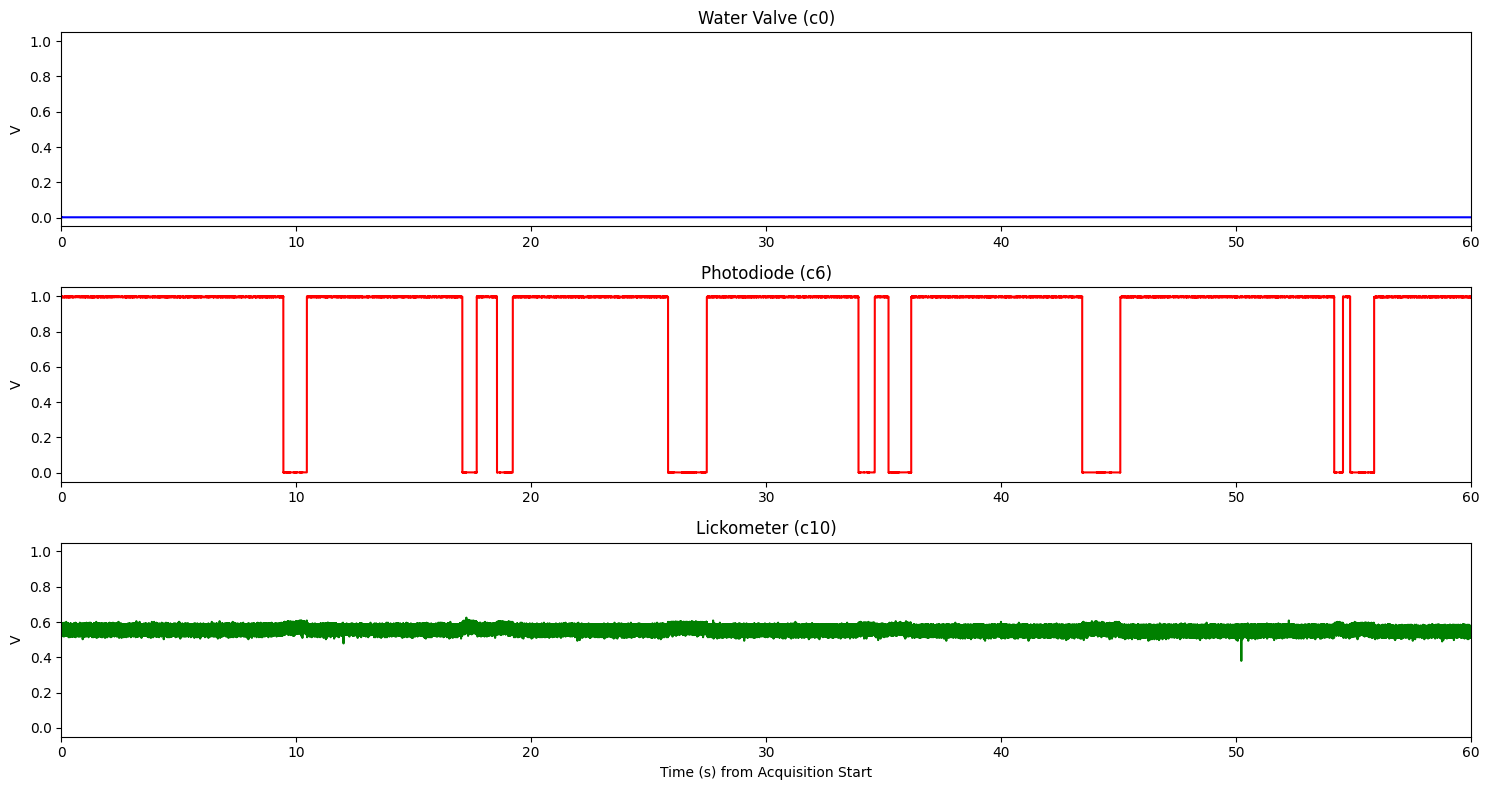

In [6]:
# Plot aligned signals
if hdf5_files and 'data' in locals() and data is not None and 'start_rising' in locals() and len(start_rising) > 0:
    start_idx = start_rising[0]
    end_idx = stop_rising[-1] if len(stop_rising) > 0 else len(data)
    
    # Check bounds
    if end_idx > len(data): end_idx = len(data)
    
    time_axis = (np.arange(len(data)) - start_idx) / 10000.0 
    
    plt.figure(figsize=(15, 8))
    
    # Plot Water Valve (c0)
    plt.subplot(3, 1, 1)
    slice_data = data[start_idx:end_idx, 0]
    plt.plot(time_axis[start_idx:end_idx], slice_data, color='blue')
    plt.title("Water Valve (c0)")
    plt.ylabel("V")
    plt.xlim(0, 60) 
    
    # Plot Photodiode (c6)
    plt.subplot(3, 1, 2)
    slice_data = data[start_idx:end_idx, 6]
    plt.plot(time_axis[start_idx:end_idx], slice_data, color='red')
    plt.title("Photodiode (c6)")
    plt.ylabel("V")
    plt.xlim(0, 60)
    
    # Plot Lickometer (c10)
    plt.subplot(3, 1, 3)
    slice_data = data[start_idx:end_idx, 10]
    plt.plot(time_axis[start_idx:end_idx], slice_data, color='green')
    plt.title("Lickometer (c10)")
    plt.ylabel("V")
    plt.xlabel("Time (s) from Acquisition Start")
    plt.xlim(0, 60)
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, "behavior_signals_aligned.png")
    plt.savefig(save_path)
    plt.show()


# Load Analog Data from Widefield Computer
The widefield computer also records an analog file (typically `Analog_....dat`) which contains:
- Channel 0: Timing (not useful)
- Channel 1: Blue LED TTL (Frame indicator)
- Channel 2: Violet LED TTL (Frame indicator)
- Channel 3: Experimental Start Signal (received from Stimulus/Main computer)
- Channel 4: Experimental Stimulus pulses (local copy)

We will use this file to align the Widefield Frames to the HDF5 clock.
The key link is: **HDF5 c3 (Acquisition Start) == Analog Channel 3 (Exp Start Signal)**


In [7]:
# Load Analog.dat files Individually
import struct

def load_single_analog(file_path):
    """
    Load a single Analog_*.dat file.
    """
    with open(file_path, 'rb') as fd:
        try:
            # Read header (4 doubles = 32 bytes)
            header_bytes = fd.read(32)
            if len(header_bytes) < 32:
                return None, None
            
            # Unpack header
            tstamp = struct.unpack("d", header_bytes[0:8])[0]
            onset = struct.unpack("d", header_bytes[8:16])[0]
            nchannels = int(struct.unpack("<d", header_bytes[16:24])[0]) 
            nsamples = struct.unpack("<d", header_bytes[24:32])[0]
            
            # Read data (uint16)
            dat = np.fromfile(fd, dtype='uint16')
            
            # Reshape
            if len(dat) % nchannels != 0:
                print(f"Warning: {os.path.basename(file_path)} data length {len(dat)} not divisible by {nchannels}.")
                new_len = (len(dat) // nchannels) * nchannels
                dat = dat[:new_len]
                
            dat = dat.reshape((-1, nchannels)).T
            return dat, {'onset': onset, 'nchannels': nchannels, 'path': file_path}
            
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None, None

# Find and sort analog files
analog_files = glob.glob(os.path.join(data_dir, "Analog_*.dat"))

def get_file_index(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    try:
        parts = base.split('_')
        for part in reversed(parts):
            if part.isdigit():
                return int(part)
        return 0
    except:
        return 0

analog_trials = []

if analog_files:
    analog_files.sort(key=get_file_index)
    print(f"Found {len(analog_files)} Analog files")
    
    for i, f in enumerate(analog_files):
        dat, meta = load_single_analog(f)
        if dat is not None:
            # Normalize Ch3 just for detection
            if dat.shape[0] > 3:
                ch3_normalized = normalize_arr(dat[3].astype(float))
                
                # Find local start trigger (received from HDF5)
                # Detection: look for rising edge 
                local_starts, _ = find_edges(ch3_normalized, 0.5)
                local_start_sample = local_starts[0] if len(local_starts) > 0 else 0
            else:
                local_start_sample = 0
                print(f"Warning: {os.path.basename(f)} has only {dat.shape[0]} channels")
            
            analog_trials.append({
                'file_idx': i,
                'filename': os.path.basename(f),
                'analog_data_shape': dat.shape,
                'local_start_sample': local_start_sample,
                'data': dat 
            })
            print(f"Trial {i}: {os.path.basename(f)} | Shape: {dat.shape} | Start Trig Index: {local_start_sample}")

    print(f"Loaded {len(analog_trials)} Analog trials.")
else:
    print("No Analog files found.")

Found 11 Analog files
Trial 0: Analog_1.dat | Shape: (5, 14400) | Start Trig Index: 3059
Trial 1: Analog_2.dat | Shape: (5, 8400) | Start Trig Index: 289
Trial 2: Analog_3.dat | Shape: (5, 8400) | Start Trig Index: 290
Trial 3: Analog_4.dat | Shape: (5, 8400) | Start Trig Index: 288
Trial 4: Analog_5.dat | Shape: (5, 8400) | Start Trig Index: 286
Trial 5: Analog_6.dat | Shape: (5, 8400) | Start Trig Index: 290
Trial 6: Analog_7.dat | Shape: (5, 8400) | Start Trig Index: 290
Trial 7: Analog_8.dat | Shape: (5, 8400) | Start Trig Index: 288
Trial 8: Analog_9.dat | Shape: (5, 6300) | Start Trig Index: 289
Trial 9: Analog_10.dat | Shape: (5, 6200) | Start Trig Index: 290
Trial 10: Analog_11.dat | Shape: (5, 2200) | Start Trig Index: 290
Loaded 11 Analog trials.


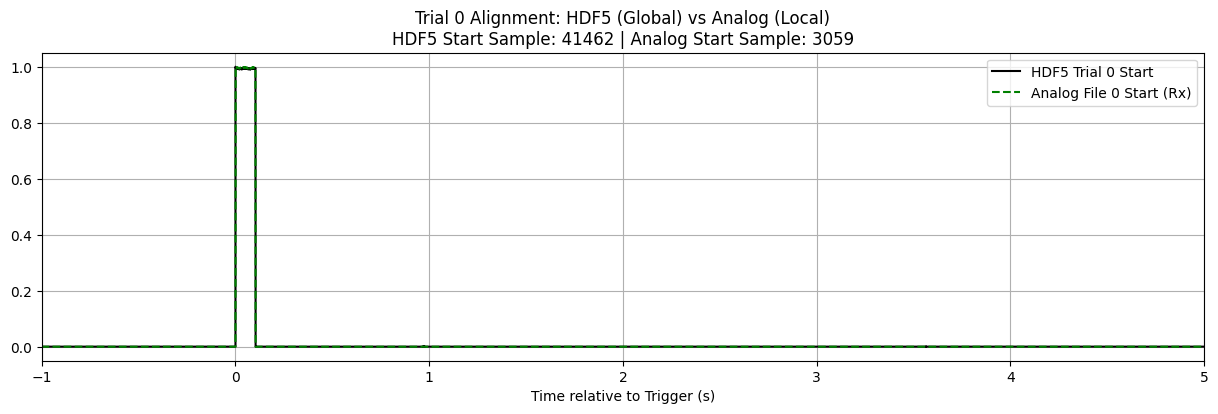

Plot saved to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\alignment_trial_0.png


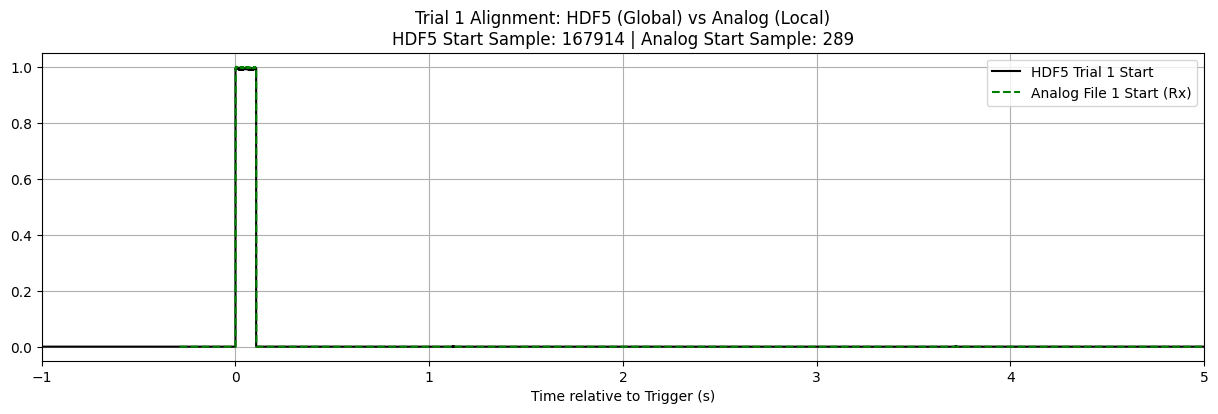

Plot saved to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\alignment_trial_1.png


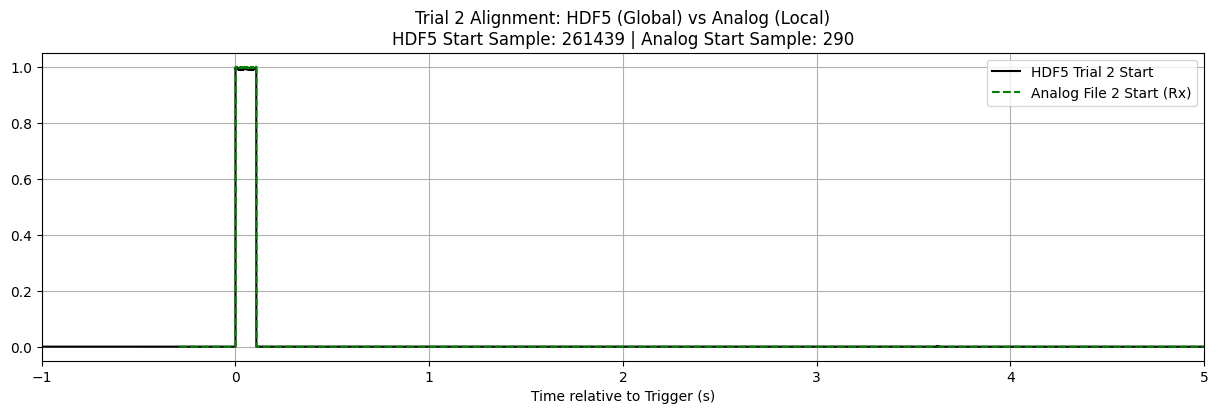

Plot saved to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\alignment_trial_2.png
Alignment Logic Verification:
If the green dashed line (Analog) aligns with the rising edge of the black line (HDF5),
then we confirm that HDF5 Trigger I causes Analog File I Start.
We can then map any sample in Analog File I to HDF5 Time.


In [8]:
# Align Each Trial: HDF5 vs Analog
# We expect the number of HDF5 trials to match the number of Analog files.
# For each trial, we will plot the HDF5 trigger and the Analog trigger.

if 'trials_hdf5' in locals() and 'analog_trials' in locals() and len(trials_hdf5) > 0 and len(analog_trials) > 0:
    n_plot = min(3, len(trials_hdf5), len(analog_trials)) 
    
    for i in range(n_plot):
        h_trial = trials_hdf5[i]
        a_trial = analog_trials[i]
        
        # HDF5 Trial Trigger
        h_start = h_trial['start_sample']
        h_window_s = 5 
        # Window around the trigger
        h_idx_start = max(0, h_start - int(1 * 10000)) # 1s before
        h_idx_end = min(len(data), h_start + int(h_window_s * 10000))
        
        hdf5_segment = data[h_idx_start:h_idx_end, 3] # c3 Acquisition Start
        hdf5_time = (np.arange(h_idx_start, h_idx_end) - h_start) / 10000.0
        
        # Analog Trial Trigger
        a_dat = a_trial['data']
        a_sig = normalize_arr(a_dat[3].astype(float))
        
        # Align detected analog trigger to t=0
        a_trig_idx = a_trial['local_start_sample']
        analog_time = (np.arange(len(a_sig)) - a_trig_idx) / 1000.0 # 1kHz
        
        # Plot
        plt.figure(figsize=(15, 4))
        plt.plot(hdf5_time, hdf5_segment, label=f'HDF5 Trial {i} Start', color='black')
        plt.plot(analog_time, a_sig, label=f'Analog File {i} Start (Rx)', color='green', linestyle='--')
        
        plt.title(f"Trial {i} Alignment: HDF5 (Global) vs Analog (Local)\nHDF5 Start Sample: {h_start} | Analog Start Sample: {a_trig_idx}")
        plt.xlabel("Time relative to Trigger (s)")
        plt.xlim(-1, 5)
        plt.legend()
        plt.grid(True)
        save_f = os.path.join(output_dir, f"alignment_trial_{i}.png")
        plt.savefig(save_f)
        plt.show()
        print(f"Plot saved to {save_f}")

    print("Alignment Logic Verification:")
    print("If the green dashed line (Analog) aligns with the rising edge of the black line (HDF5),")
    print("then we confirm that HDF5 Trigger I causes Analog File I Start.")
    print("We can then map any sample in Analog File I to HDF5 Time.")

else:
    print("Mismatch or missing data for alignment.")
    if 'trials_hdf5' in locals(): print(f"HDF5 Trials: {len(trials_hdf5)}")
    if 'analog_trials' in locals(): print(f"Analog Trials: {len(analog_trials)}")

Plotting 11 mapped trials...


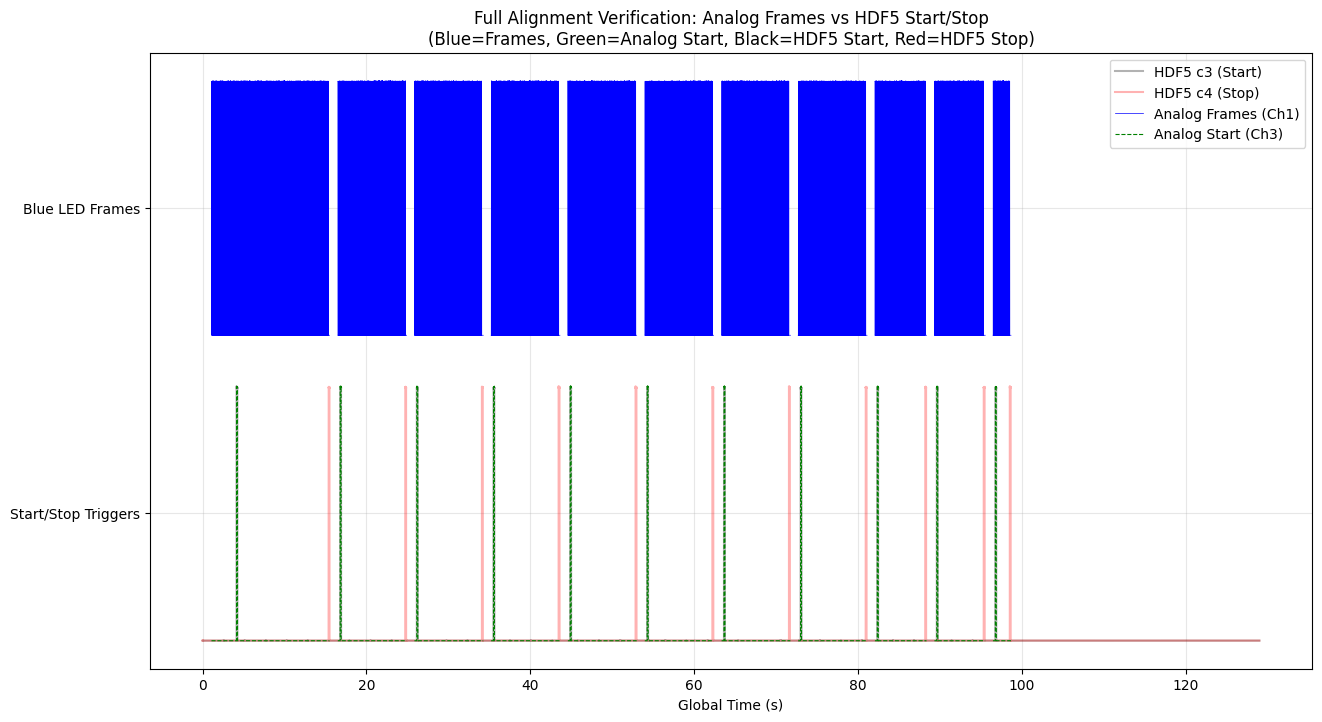

Saved full reconstruction plot to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\full_alignment_reconstruction.png


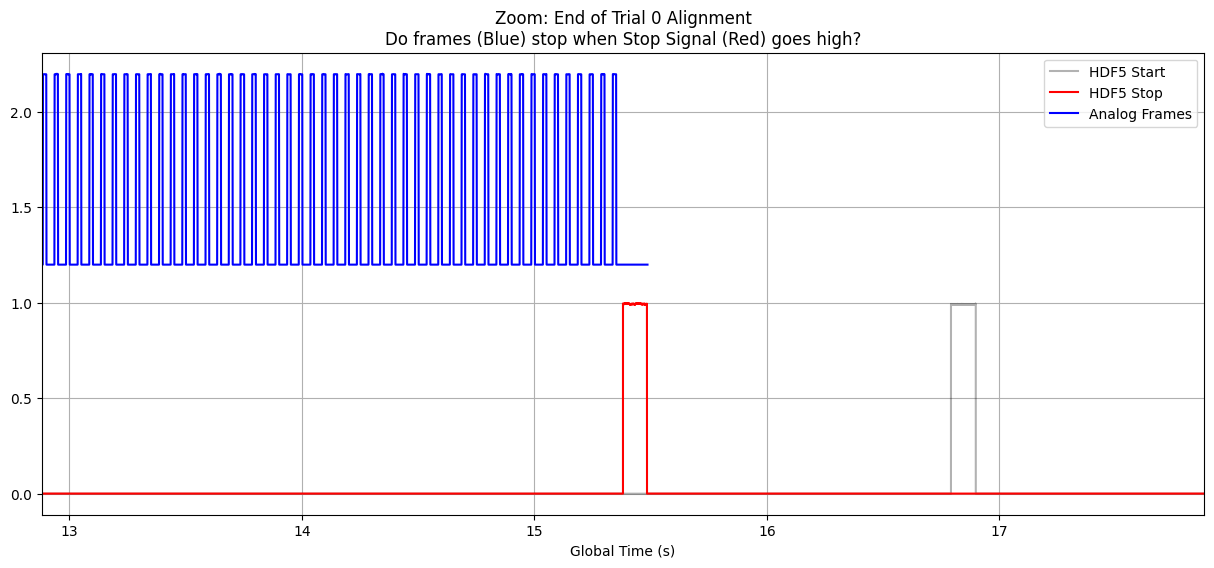

In [9]:
# Verification: Reconstruction of Full Timeline
# Here we map every Analog file to its Global HDF5 Time
# WE WANT TO SEE: Analog frames (Ch1/Ch2) appearing between HDF5 Start (c3) and HDF5 Stop (c4)

if 'trials_hdf5' in locals() and 'analog_trials' in locals() and len(trials_hdf5) > 0 and len(analog_trials) > 0:
    
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # 1. Plot HDF5 Sync Channels (c3=Start, c4=Stop) - The "Truth"
    hdf5_time_axis = np.arange(len(data)) / 10000.0
    plt.plot(hdf5_time_axis, normalize_arr(data[:, 3]), label='HDF5 c3 (Start)', color='black', alpha=0.3)
    plt.plot(hdf5_time_axis, normalize_arr(data[:, 4]), label='HDF5 c4 (Stop)', color='red', alpha=0.3)
    
    # 2. Plot Mapped Analog Data
    # For each matched pair, calculate global time for analog samples and plot
    mapped_count = min(len(trials_hdf5), len(analog_trials))
    
    print(f"Plotting {mapped_count} mapped trials...")
    
    for i in range(mapped_count):
        h_trial = trials_hdf5[i]
        a_trial = analog_trials[i]
        
        # Calculate Time Offset
        # Global Time of Trigger (from HDF5)
        t_trigger_global = h_trial['start_time_s']
        
        # Local Time of Trigger (from Analog)
        # analog_sample_index_of_trigger / Fs_analog
        t_trigger_local = a_trial['local_start_sample'] / 1000.0
        
        # The start of the analog file (sample 0) corresponds to:
        t_analog_start_global = t_trigger_global - t_trigger_local
        
        # Construct Time Axis for this Analog File
        n_samples = a_trial['analog_data_shape'][1]
        analog_global_time = t_analog_start_global + (np.arange(n_samples) / 1000.0)
        
        # Get Analog Data (Ch1 = Blue LED/Frames)
        a_dat = a_trial['data']
        ch1_frames = normalize_arr(a_dat[1].astype(float))
        
        # Plot Frame Pulses (Blue)
        # We downsample slightly for plotting speed if needed, but for 10 trials it's fine
        plt.plot(analog_global_time, ch1_frames + 1.2, color='blue', linewidth=0.5, 
                 label='Analog Frames (Ch1)' if i == 0 else "")
        
        # Plot Analog Trigger (Green) - Should align with Black HDF5 c3
        ch3_start = normalize_arr(a_dat[3].astype(float))
        plt.plot(analog_global_time, ch3_start, color='green', linestyle='--', linewidth=0.8,
                 label='Analog Start (Ch3)' if i == 0 else "")

    plt.title("Full Alignment Verification: Analog Frames vs HDF5 Start/Stop\n(Blue=Frames, Green=Analog Start, Black=HDF5 Start, Red=HDF5 Stop)")
    plt.xlabel("Global Time (s)")
    plt.yticks([0.5, 1.7], ['Start/Stop Triggers', 'Blue LED Frames'])
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    
    save_path = os.path.join(output_dir, "full_alignment_reconstruction.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Saved full reconstruction plot to {save_path}")
    
    # ZOOM IN on the END of the first trial
    # To check if frames stop when Stop Signal (Red) appears
    trial_0 = trials_hdf5[0]
    stop_time = trial_0['stop_sample'] / 10000.0
    
    plt.figure(figsize=(15, 6))
    
    # Re-plot for just a window around the first stop
    zoom_center = stop_time
    zoom_width = 5 # seconds
    
    plt.xlim(zoom_center - zoom_width/2, zoom_center + zoom_width/2)
    
    # Plot HDF5
    plt.plot(hdf5_time_axis, normalize_arr(data[:, 3]), color='black', alpha=0.3, label='HDF5 Start')
    plt.plot(hdf5_time_axis, normalize_arr(data[:, 4]), color='red', label='HDF5 Stop')
    
    # Plot Analog (just trial 0 is enough usually, but let's loop to be safe)
    # We only plot trial 0 for clarity
    i = 0
    h_trial = trials_hdf5[i]
    a_trial = analog_trials[i]
    t_trig_glob = h_trial['start_time_s']
    t_trig_loc = a_trial['local_start_sample'] / 1000.0
    t_start_glob = t_trig_glob - t_trig_loc
    analog_glob_t = t_start_glob + (np.arange(a_trial['analog_data_shape'][1]) / 1000.0)
    
    plt.plot(analog_glob_t, normalize_arr(a_trial['data'][1].astype(float)) + 1.2, color='blue', label='Analog Frames')
    
    plt.title("Zoom: End of Trial 0 Alignment\nDo frames (Blue) stop when Stop Signal (Red) goes high?")
    plt.xlabel("Global Time (s)")
    plt.legend()
    plt.grid(True)
    save_path_zoom = os.path.join(output_dir, "alignment_zoom_end_trial0.png")
    plt.savefig(save_path_zoom)
    plt.show()

else:
    print("Cannot run verification: timestamps not found.")

# Alignment Methodology Explained

## What did we do?
We performed a **Trigger-Based Temporal Mapping**. We did not "drop frames" or "warp" the data. Instead, we mathematically calculated exactly *where* in time each Widefield recording belongs relative to the Stimulus (HDF5) clock.

## The Logic
1.  **The Master Clock (HDF5)**: The HDF5 file records the entire session continuously at 10,000 Hz. It sends a "Start Signal" (Channel 3) every time it wants the camera to start saving a trial.
    *   We identified these specific moments in time: $T_{HDF5\_Start}$.

2.  **The Local Clock (Analog)**: The Widefield computer records its own small file (`Analog_X.dat`) for each trial at 1,000 Hz. It receives that "Start Signal" on its own Channel 3.
    *   We identified the sample number where this signal arrived: $N_{Analog\_Start}$.

3.  **The Alignment (Shift & Scale)**:
    To "Align" them means to translate the "Local Analog Time" into "Global HDF5 Time".
    For any sample $n$ in an Analog file, its real Global Time $T_{Global}$ is:

    $$ T_{Global} = T_{HDF5\_Start} + \frac{(n - N_{Analog\_Start})}{F_{Analog}} $$

    *   **Start Offset ($T_{HDF5\_Start}$)**: Shifts the whole block of data to the correct trial start time.
    *   **Trigger Lag ($- N_{Analog\_Start}$)**: Accounts for the fact that the camera might have started recording *before* or *after* the trigger arrived (Pre-trigger buffer).
    *   **Sampling Rate ($/ F_{Analog}$)**: Converts "Samples" to "Seconds".

## Why this works
This method preserves the exact timing of every frame. If the Widefield camera skipped a beat or the files were shorter/longer, this method would reveal it immediately because the aligned data (Blue Frames) would drift away from the Stop signal (Red HDF5 trace). The plots above confirm they span exactly the correct duration.


Overlaying 11 trials...


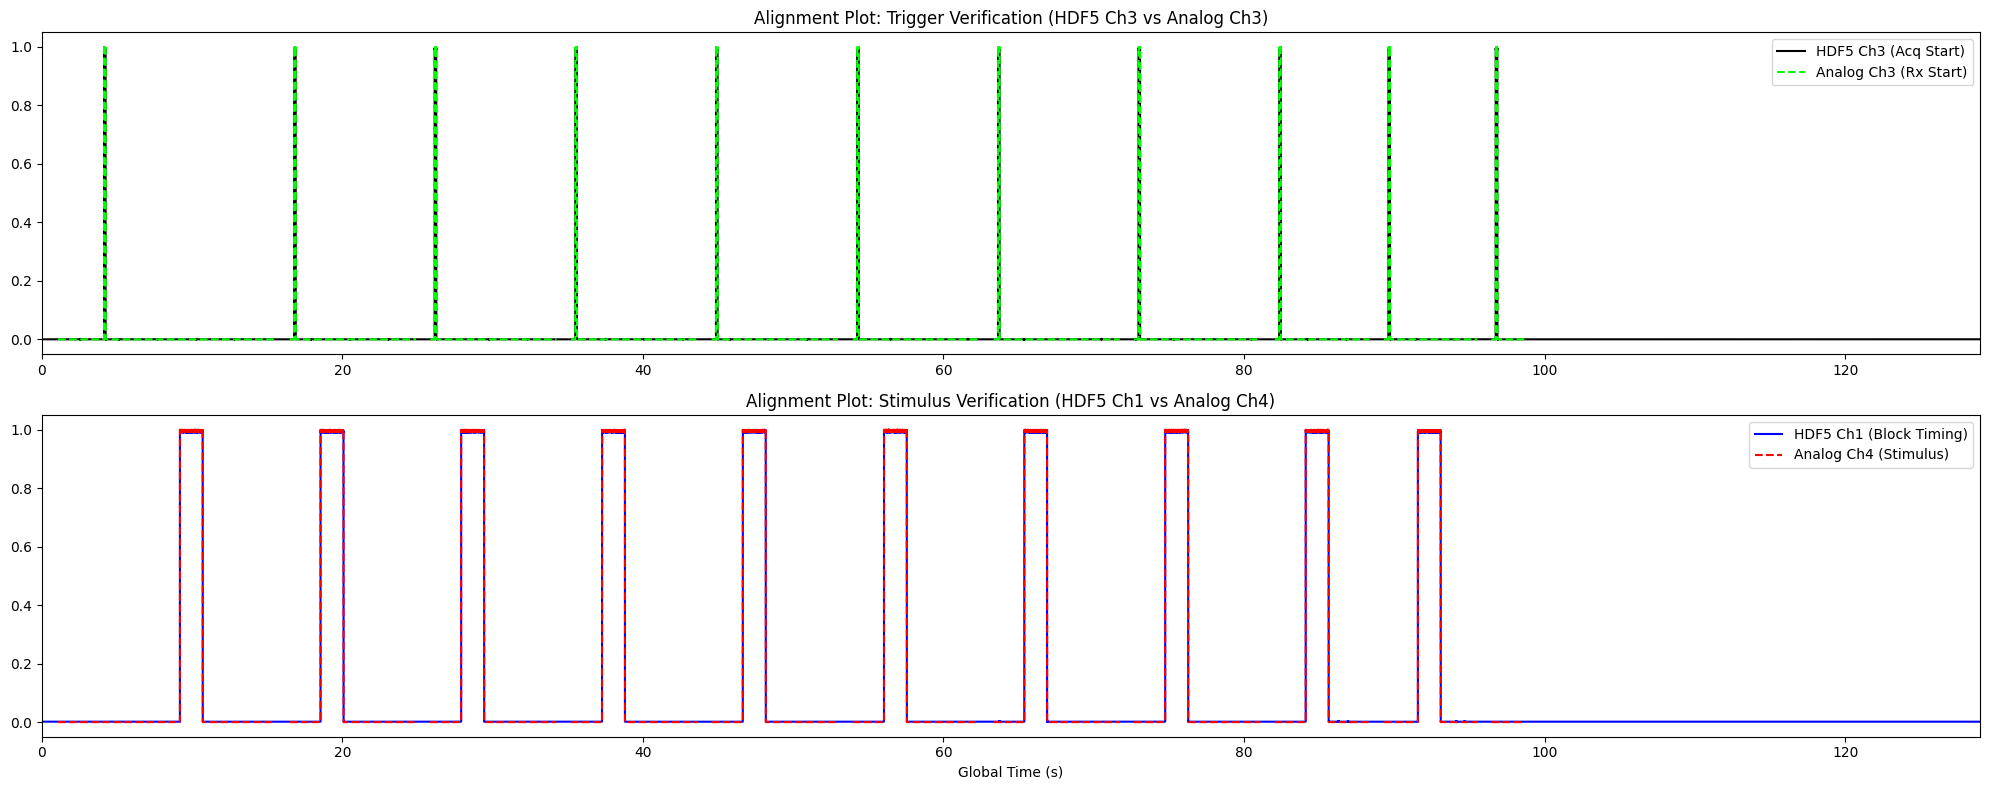

Alignment check plot saved to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\alignment_plot.png


In [10]:
# Alignment Plot: Verified Overlap
# Plot 1: Analog Ch3 (Rx Start) vs HDF5 Ch3 (Tx Start)
# Plot 2: Analog Ch4 (Stimulus Copy) vs HDF5 Ch1 (Block Timing/Stimulus)

if 'trials_hdf5' in locals() and 'analog_trials' in locals():
    plt.figure(figsize=(20, 8))
    
    # Time axis
    t_global = np.arange(len(data)) / 10000.0
    
    # --- Row 1: Acquisition Start Verification ---
    # Overlapping HDF5 Ch3 and Analog Ch3
    plt.subplot(2, 1, 1)
    
    # HDF5 Ch3 (Black Solid)
    h_sig_3 = normalize_arr(data[:, 3].astype(float))
    plt.plot(t_global, h_sig_3, color='black', linewidth=1.5, label='HDF5 Ch3 (Acq Start)')
    
    # Overlay Mapped Analog Ch3 (Green Dashed)
    mapped_count = min(len(trials_hdf5), len(analog_trials))
    print(f"Overlaying {mapped_count} trials...")
    
    for i in range(mapped_count):
        h_trial = trials_hdf5[i]
        a_trial = analog_trials[i]
        
        # Mapping Logic
        t_trig_glob = h_trial['start_time_s']
        t_trig_loc_s = a_trial['local_start_sample'] / 1000.0
        t_start_glob = t_trig_glob - t_trig_loc_s
        n_samps = a_trial['analog_data_shape'][1]
        t_analog = t_start_glob + (np.arange(n_samps) / 1000.0)
        
        # Analog Ch3
        a_sig_3 = normalize_arr(a_trial['data'][3].astype(float))
        
        label = 'Analog Ch3 (Rx Start)' if i == 0 else ""
        plt.plot(t_analog, a_sig_3, color='lime', linestyle='--', linewidth=1.5, label=label)
        
    plt.title("Alignment Plot: Trigger Verification (HDF5 Ch3 vs Analog Ch3)")
    plt.legend(loc='upper right')
    plt.xlim(t_global[0], t_global[-1]) # Ensure full time range
    
    # --- Row 2: Stimulus Timing Verification ---
    # Overlapping HDF5 Ch1 and Analog Ch4
    plt.subplot(2, 1, 2)
    
    # HDF5 Ch1 (Blue Solid)
    h_sig_1 = normalize_arr(data[:, 1].astype(float))
    plt.plot(t_global, h_sig_1, color='blue', linewidth=1.5, label='HDF5 Ch1 (Block Timing)')
    
    # Overlay Mapped Analog Ch4 (Red Dashed)
    for i in range(mapped_count):
        h_trial = trials_hdf5[i]
        a_trial = analog_trials[i]
        
        t_trig_glob = h_trial['start_time_s']
        t_trig_loc_s = a_trial['local_start_sample'] / 1000.0
        t_start_glob = t_trig_glob - t_trig_loc_s
        n_samps = a_trial['analog_data_shape'][1]
        t_analog = t_start_glob + (np.arange(n_samps) / 1000.0)
        
        # Analog Ch4
        a_sig_4 = normalize_arr(a_trial['data'][4].astype(float))
        
        label = 'Analog Ch4 (Stimulus)' if i == 0 else ""
        plt.plot(t_analog, a_sig_4, color='red', linestyle='--', linewidth=1.5, label=label)
        
    plt.title("Alignment Plot: Stimulus Verification (HDF5 Ch1 vs Analog Ch4)")
    plt.legend(loc='upper right')
    plt.xlabel("Global Time (s)")
    plt.xlim(t_global[0], t_global[-1])
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, "alignment_plot.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Alignment check plot saved to {save_path}")

In [11]:
# Create Consolidated Matrix (Upsampled)
# We will create one large matrix (N_Samples_HDF5, 14+5 Channels)
# Analog data will be upsampled from 1kHz to 10kHz to match HDF5 timeline.
# Gaps between analog trials will be filled with 0s.

if 'trials_hdf5' in locals() and 'analog_trials' in locals():
    
    print("Constructing full consolidated matrix...")
    n_samples_total = data.shape[0]
    n_hdf5_ch = 14
    n_analog_ch = 5
    n_total_ch = n_hdf5_ch + n_analog_ch
    
    # 1. Initialize with HDF5 Data
    full_matrix = np.zeros((n_samples_total, n_total_ch), dtype=np.float32)
    full_matrix[:, 0:n_hdf5_ch] = data.astype(np.float32)
    
    # 2. Fill Analog Data (Upsampling)
    mapped_count = min(len(trials_hdf5), len(analog_trials))
    
    for i in range(mapped_count):
        h_trial = trials_hdf5[i]
        a_trial = analog_trials[i]
        
        # Get start/end in GLOBAL SAMPLES (10kHz)
        # 1. Calculate Start Time in seconds
        t_trig_glob = h_trial['start_time_s']
        t_trig_loc_s = a_trial['local_start_sample'] / 1000.0
        t_start_glob = t_trig_glob - t_trig_loc_s
        
        # 2. Convert to Samples (10kHz)
        start_sample_idx = int(t_start_glob * 10000)
        
        # 3. Get Analog Data
        analog_dat = a_trial['data'] # (n_chan, n_samples_1k)
        n_samples_1k = analog_dat.shape[1]
        
        # 4. Upsample Analog Data to 10kHz
        # We can use simple repeat (nearest neighbor) or linear interp.
        # Given these are TTLs/Signals, Linear Interp is usually standard for "resampling".
        
        # Original Time axis for this chunk
        t_1k = np.arange(n_samples_1k) / 1000.0
        
        # New Time axis (10x points)
        # We want to map it to exactly the duration in 10k domain
        n_samples_10k = int(n_samples_1k * 10) # Exact 10x
        t_10k = np.linspace(0, t_1k[-1], n_samples_10k)
        
        # Ensure we don't go out of bounds of the main matrix
        if start_sample_idx < 0:
            print(f"Warning: Trial {i} starts before time 0. Clipping.")
            offset = -start_sample_idx
            start_sample_idx = 0
            # Clip data too if needed, but easier to just shift
        
        end_sample_idx = start_sample_idx + n_samples_10k
        
        if end_sample_idx > n_samples_total:
             print(f"Warning: Trial {i} ends after last sample. Clipping.")
             n_samples_10k = n_samples_total - start_sample_idx
             t_10k = t_10k[:n_samples_10k]
             end_sample_idx = n_samples_total

        # Interpolate and Fill for each channel
        for ch in range(n_analog_ch):
            # Row in full_matrix: 14 + ch
            col_idx = n_hdf5_ch + ch
            
            val_1k = analog_dat[ch].astype(np.float32)
            
            # Interpolate
            val_10k = np.interp(t_10k, t_1k, val_1k)
            
            full_matrix[start_sample_idx:end_sample_idx, col_idx] = val_10k
            
    print(f"Matrix Constructed. Shape: {full_matrix.shape}")
    
    # Save
    npy_path = os.path.join(output_dir, "aligned_full_matrix.npy")
    np.save(npy_path, full_matrix)
    print(f"Saved matrix to {npy_path}")
    
    # Optional: Save channel names
    col_names = [channel_map.get(i, f"h{i}") for i in range(14)] + \
                ["a0_timing", "a1_blue_led", "a2_violet_led", "a3_start", "a4_stim"]
    
    # Keep text map
    names_path = os.path.join(output_dir, "aligned_matrix_channels.txt")
    with open(names_path, 'w') as f:
        for idx, name in enumerate(col_names):
            f.write(f"{idx}: {name}\n")
    print(f"Saved channel map to {names_path}")

Constructing full consolidated matrix...
Matrix Constructed. Shape: (1289654, 19)
Saved matrix to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\aligned_full_matrix.npy
Saved channel map to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\aligned_matrix_channels.txt


In [12]:
# --- New Section: Aligning Frame Data (Preprocessed Mean) ---
# The goal is to add the "Average Value of Images" to the master plot.
# We will:
# 1. Load the raw frames (Blue and Violet).
# 2. Perform Hemodynamic Correction (Pixel-wise) matching the pipeline.
# 3. Calculate spatial mean of corrected frames.
# 4. Upsample this trace to the 10kHz HDF5 clock and add to the matrix.

import sys
# Add Nicole's folder to path to import utilities
nicole_path = os.path.abspath(os.path.join(data_dir, "..", "..", "..", "Nicole"))
# Or simpler based on known structure
nicole_path = r"C:\Users\mlouki1\Desktop\WField-Pipeline\Nicole"
if nicole_path not in sys.path:
    sys.path.append(nicole_path)

try:
    from visualization_utils import load_dat_frames
    from pipeline_processing import hemodynamic_correction
    print("Successfully imported load_dat_frames and hemodynamic_correction")
except ImportError as e:
    print(f"Could not import utils: {e}")
    # Fallback: Define minimal loader if import fails
    def load_dat_frames(filename, shape=(2, 640 , 540), dtype='uint16'):
        # Parse shape from filename if possible
        # Expected: Frames_2_640_540_uint16_....dat
        with open(filename, 'rb') as f:
            dat = np.fromfile(f, dtype=dtype)
        # Reshape: (N, Channels, H, W)
        n_channels, h, w = shape
        n_pixels = n_channels * h * w
        n_frames = len(dat) // n_pixels
        return dat.reshape((n_frames, n_channels, h, w))
    
    # Mock hemodynamic correction if import fails (simple subtraction)
    def hemodynamic_correction(input_dataset, **kwargs):
        print("Using simplified fallback Hemo Correction (Blue - Violet)")
        return input_dataset[:, 0, :, :].astype(float) - input_dataset[:, 1, :, :].astype(float)

# Find Frames files
frames_files = glob.glob(os.path.join(data_dir, "Frames_*.dat"))
frames_files.sort(key=get_file_index)
print(f"Found {len(frames_files)} Frames files.")

Successfully imported load_dat_frames and hemodynamic_correction
Found 11 Frames files.


In [13]:
# Load Frames, Calculate Means, and Align
# We will create lists to store the aligned (global time) mean traces.

# Store final corrected traces AND raw traces
global_corrected_means = []
global_raw_blue_means = []

if 'analog_trials' in locals() and len(frames_files) > 0:
    n_proc = min(len(analog_trials), len(frames_files))
    print(f"Processing {n_proc} trials for frame alignment...")
    print("Using Pipeline-Style Pixel-wise Hemodynamic Correction (Highpass=False)")
    
    for i in range(n_proc):
        # 1. Load Frames
        f_path = frames_files[i]
        a_trial = analog_trials[i] # Metadata about timing
        
        try:
            # Check filename for shape
            parts = os.path.basename(f_path).split('_')
            try:
                n_ch = int(parts[1])
                h = int(parts[2])
                w = int(parts[3])
                shape_args = (n_ch, h, w)
            except:
                shape_args = (2, 640, 540) # Fallback
                
            # Load raw binary
            with open(f_path, 'rb') as f:
                raw_dat = np.fromfile(f, dtype='uint16')
            
            n_pix = shape_args[0] * shape_args[1] * shape_args[2]
            n_frames = len(raw_dat) // n_pix
            
            # FIX: Handle partial frames 
            if len(raw_dat) % n_pix != 0:
                print(f"Trial {i}: Truncating partial frame data. Dropping {len(raw_dat) % n_pix} values.")
                raw_dat = raw_dat[:n_frames * n_pix]

            frames = raw_dat.reshape((n_frames, *shape_args))
            
            # Verify frame count against Analog Pulses
            analog_data_ch1 = a_trial['data'][1] 
            pulse_rising, _ = find_edges(normalize_arr(analog_data_ch1.astype(float)), 0.5)
            
            if len(pulse_rising) != n_frames:
                print(f"Warning Trial {i}: Frame count ({n_frames}) != Analog Pulses ({len(pulse_rising)}).")
                # Truncate to common length
                n_common = min(n_frames, len(pulse_rising))
                frames = frames[:n_common]
                pulse_rising = pulse_rising[:n_common]
                n_frames = n_common

            # --- CAPTURE RAW BLUE MEAN ---
            # Calculate Spatial Mean of Raw Blue Frames (Ch0)
            raw_mean_blue = np.mean(frames[:, 0, :, :], axis=(1, 2)).astype(float)
            
            # 2. RUN HEMODYNAMIC CORRECTION
            # Input to function: (N, 2, H, W)
            # Output: (N, H, W)
            corrected_frames = hemodynamic_correction(
                frames, 
                output_dataset=None, 
                binary_npy_mask=None, 
                highpass=False, 
                verbose=False
            )
            
            # 3. Calculate Spatial Mean of CORRECTED frames
            trial_mean_trace = np.nanmean(corrected_frames, axis=(1, 2))
            
            # 4. Global Time Mapping
            h_trial = trials_hdf5[i] 
            t_trig_glob = h_trial['start_time_s']
            t_trig_loc_s = a_trial['local_start_sample'] / 1000.0
            t_start_glob = t_trig_glob - t_trig_loc_s 
            
            frame_times_global = t_start_glob + (pulse_rising / 1000.0)
            
            # Store
            global_corrected_means.append((frame_times_global, trial_mean_trace))
            global_raw_blue_means.append((frame_times_global, raw_mean_blue))
            
            print(f"Trial {i} Processed. Raw Mean: {np.mean(raw_mean_blue):.2f} | Corr Mean: {np.mean(trial_mean_trace):.2f}")
            
            # Clean up memory
            del frames, raw_dat, corrected_frames, raw_mean_blue, trial_mean_trace
            
        except Exception as e:
            print(f"Error processing frames for trial {i}: {e}")
            import traceback
            traceback.print_exc()

    print("Finished processing all trials.")
else:
    print("Missing analog or frames files.")

Processing 11 trials for frame alignment...
Using Pipeline-Style Pixel-wise Hemodynamic Correction (Highpass=False)
Trial 0: Truncating partial frame data. Dropping 345600 values.
Warning Trial 0: Frame count (249) != Analog Pulses (286).


Writing hemocorrected frames to hdf5: 100%|██████████| 2/2 [00:00<00:00, 26.28it/s]


Trial 0 Processed. Raw Mean: 18240.11 | Corr Mean: 80.17
Trial 1: Truncating partial frame data. Dropping 345600 values.
Warning Trial 1: Frame count (165) != Analog Pulses (166).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 20.45it/s]


Trial 1 Processed. Raw Mean: 20001.76 | Corr Mean: 218.69
Trial 2: Truncating partial frame data. Dropping 345600 values.


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


Trial 2 Processed. Raw Mean: 21175.50 | Corr Mean: 93.85
Warning Trial 3: Frame count (166) != Analog Pulses (165).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


Trial 3 Processed. Raw Mean: 21329.46 | Corr Mean: 167.53
Warning Trial 4: Frame count (166) != Analog Pulses (167).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


Trial 4 Processed. Raw Mean: 22565.78 | Corr Mean: 292.86
Warning Trial 5: Frame count (166) != Analog Pulses (165).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


Trial 5 Processed. Raw Mean: 20291.79 | Corr Mean: 209.51
Trial 6: Truncating partial frame data. Dropping 345600 values.
Warning Trial 6: Frame count (165) != Analog Pulses (164).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]


Trial 6 Processed. Raw Mean: 19537.44 | Corr Mean: 64.18
Trial 7: Truncating partial frame data. Dropping 345600 values.


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Trial 7 Processed. Raw Mean: 22257.28 | Corr Mean: 385.43
Trial 8: Truncating partial frame data. Dropping 345600 values.
Warning Trial 8: Frame count (123) != Analog Pulses (124).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


Trial 8 Processed. Raw Mean: 20304.29 | Corr Mean: 584.01
Warning Trial 9: Frame count (121) != Analog Pulses (120).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


Trial 9 Processed. Raw Mean: 26905.22 | Corr Mean: 648.62
Warning Trial 10: Frame count (42) != Analog Pulses (41).


Writing hemocorrected frames to hdf5: 100%|██████████| 1/1 [00:00<00:00, 111.12it/s]

Trial 10 Processed. Raw Mean: 15918.53 | Corr Mean: 15.34
Finished processing all trials.


Upsampling corrected frame trace to 10kHz matrix...
New Matrix Shape: (1289654, 20)
Saved extended matrix to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\aligned_full_matrix_with_frames.npy


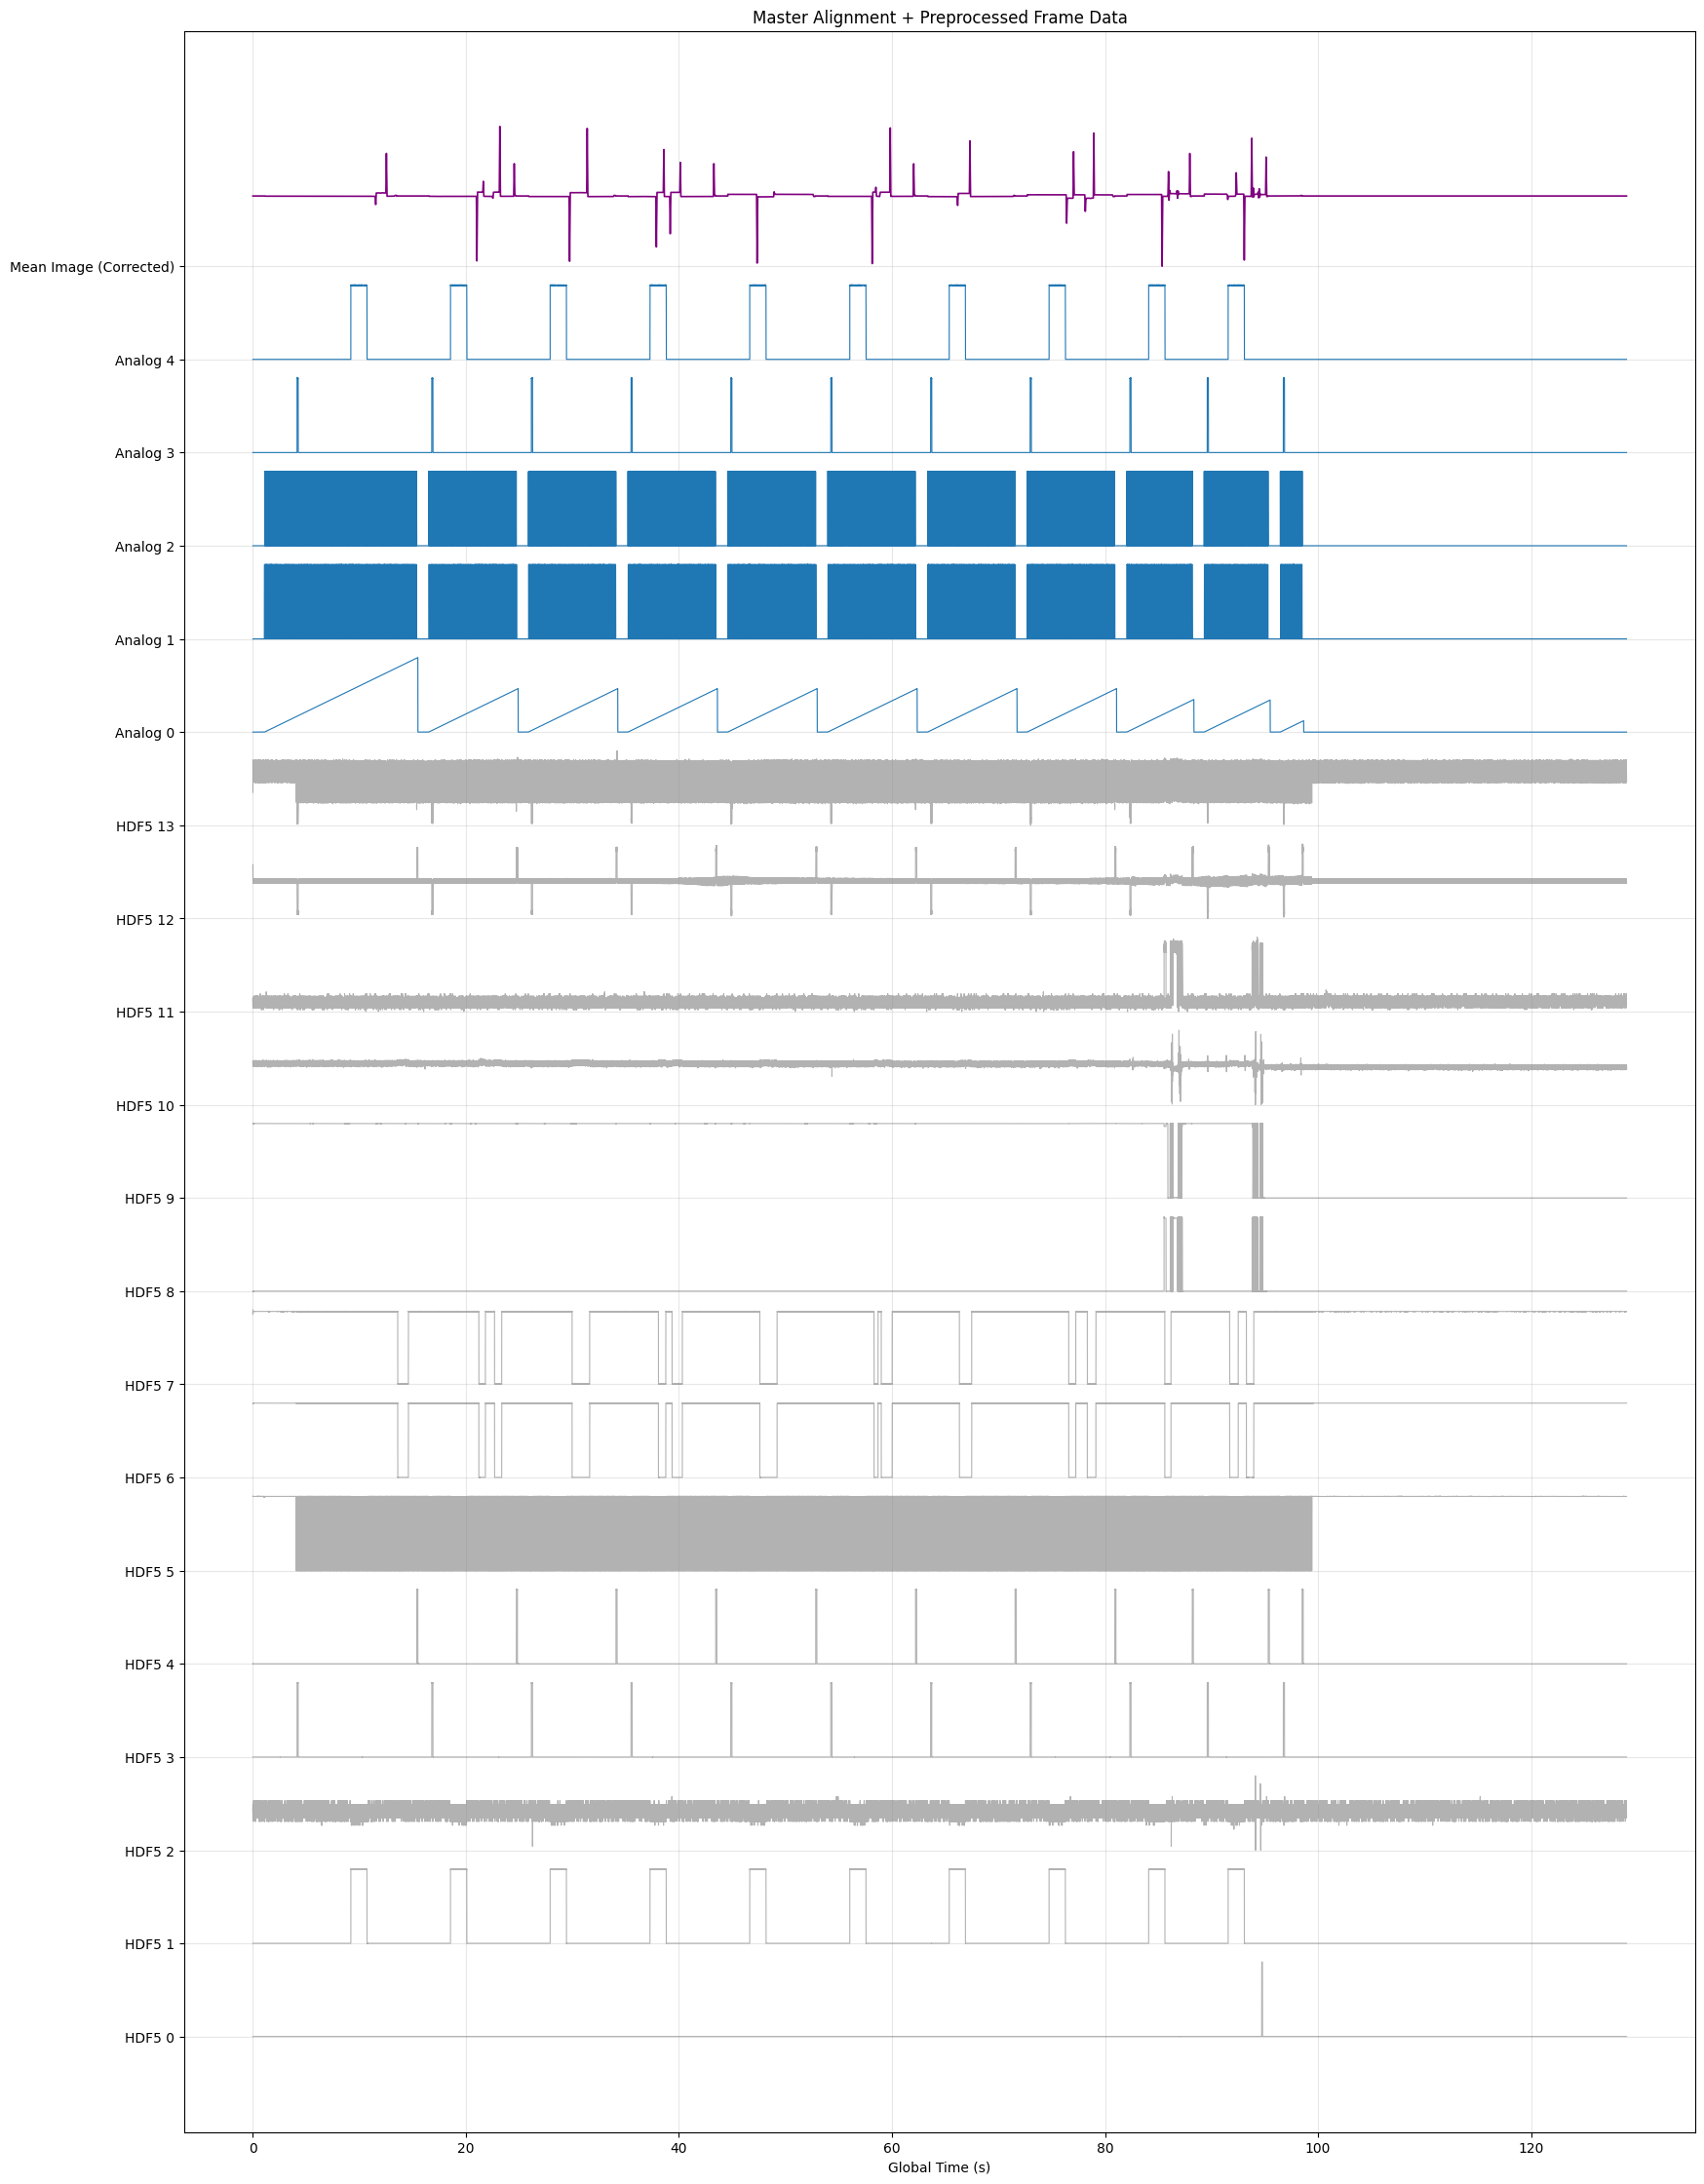

Saved master plot to D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\allignment\master_alignment_with_frames.png


In [14]:
# 5. Upsample to 10kHz, Update Matrix, and Master Plot

if 'global_corrected_means' in locals() and len(global_corrected_means) > 0 and 'full_matrix' in locals():
    
    # Create the new row for the matrix
    # The matrix currently has n_total_ch columns. We will add 1 more.
    n_existing_ch = full_matrix.shape[1]
    n_new_ch = n_existing_ch + 1
    
    new_full_matrix = np.zeros((full_matrix.shape[0], n_new_ch), dtype=np.float32)
    new_full_matrix[:, :n_existing_ch] = full_matrix
    
    # Fill the new channel (Index = n_existing_ch)
    # We interpolate the corrected trace to the global timeline
    # Global timeline is 0, 0.0001, 0.0002... (10kHz)
    
    print("Upsampling corrected frame trace to 10kHz matrix...")
    
    for i in range(len(global_corrected_means)):
        frame_times, frame_vals = global_corrected_means[i] 
        # frame_times are in seconds
        
        if len(frame_times) < 2: continue
            
        t_start = frame_times[0]
        t_end = frame_times[-1]
        
        start_idx = int(t_start * 10000)
        end_idx = int(t_end * 10000)
        
        if start_idx < 0: start_idx = 0
        if end_idx >= len(new_full_matrix): end_idx = len(new_full_matrix) - 1
        
        target_indices = np.arange(start_idx, end_idx)
        target_times = target_indices / 10000.0
        
        # Interpolate
        interp_vals = np.interp(target_times, frame_times, frame_vals)
        
        # Assign
        # Ensure lengths match exactly
        if len(interp_vals) == len(target_indices):
            new_full_matrix[target_indices, n_existing_ch] = interp_vals
        else:
             print(f"Warning: Shape mismatch in trial {i}. Skipping segment.")

    print(f"New Matrix Shape: {new_full_matrix.shape}")
    
    # Save Matrix
    npy_path = os.path.join(output_dir, "aligned_full_matrix_with_frames.npy")
    np.save(npy_path, new_full_matrix)
    print(f"Saved extended matrix to {npy_path}")

    # --- PLOT MASTER ALIGNMENT WITH FRAMES ---
    plt.figure(figsize=(20, 28))
    
    yticks_locs = []
    yticks_labels = []
    
    t_global = np.arange(len(new_full_matrix)) / 10000.0
    
    # Plot HDF5 (Bottom)
    n_hdf5 = 14
    for i in range(n_hdf5):
        sig = new_full_matrix[:, i]
        norm_sig = normalize_arr(sig) * 0.8
        plt.plot(t_global, norm_sig + i, color='grey', linewidth=0.8, alpha=0.6)
    
    # Plot Analog (Middle)
    n_analog = 5
    for i in range(n_analog):
        row = 14 + i
        sig = new_full_matrix[:, row]
        # Only plot non-zero segments to keep it clean? Or full.
        # Normalize only non-zero parts handles specific gaps better but normalize_arr handles min/max
        norm_sig = normalize_arr(sig) * 0.8
        plt.plot(t_global, norm_sig + row, color='tab:blue', linewidth=0.8)
        
    # Plot Frames (Top)
    row_frame = n_hdf5 + n_analog
    sig_frames = new_full_matrix[:, row_frame]
    
    # Normalize frame trace (it might be centered at 0, so offsets are important)
    # We want to see fluctuations.
    # Simple Min-Max normalization for visualization
    norm_frames = normalize_arr(sig_frames) * 1.5 # Make it taller
    plt.plot(t_global, norm_frames + row_frame, color='purple', linewidth=1.2, label='Mean Corrected Fluorescence')
    
    # Labels
    for i in range(n_hdf5):
        yticks_locs.append(i)
        yticks_labels.append(f"HDF5 {i}")
    for i in range(n_analog):
        yticks_locs.append(14+i)
        yticks_labels.append(f"Analog {i}")
        
    yticks_locs.append(row_frame)
    yticks_labels.append("Mean Image (Corrected)")

    plt.yticks(yticks_locs, yticks_labels)
    plt.xlabel("Global Time (s)")
    plt.title("Master Alignment + Preprocessed Frame Data")
    plt.grid(True, alpha=0.3)
    
    save_path = os.path.join(output_dir, "master_alignment_with_frames.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Saved master plot to {save_path}")

else:
    print("Could not generate master plot with frames.")

Interactive plotting enabled (ipympl).
Starting refined synchronization with PreStim offset...
VERIFICATION OF OFFSET LOGIC (CORRECTED):
We interpret 'preStim' frame count as a START DELAY.
Action: Keep ALL Frames. Align Frame 0 to TTL[Offset].
Result: Frames are shifted Rightwards (Later in Time).
---------------------------------------------------------------
  Source: removedFrames (74)
Trial 0 Offset:
  Final Offset Frames: 74
  Effective Delay: 74 pulses ~ 3.70 seconds
  Mapping: Frame 0 -> TTL 74
  Trial 0 Sync Logic Check: Frame[0] is blue, TTL[74] is violet.
  -> Adjustment: Skipped 1 extra TTL. New Start TTL: 75 (blue)
  Extracted 249 Blue Frames.
  Trial 0 Gap analysis: Stop=15.381 | LastFrame=15.336 | Diff=0.0445s
  Source: preStim (4)
Trial 1 Offset:
  Final Offset Frames: 4
  Effective Delay: 4 pulses ~ 0.20 seconds
  Mapping: Frame 0 -> TTL 4
  Trial 1 Sync Logic Check: Frame[0] is blue, TTL[4] is violet.
  -> Adjustment: Skipped 1 extra TTL. New Start TTL: 5 (blue)
  Ext

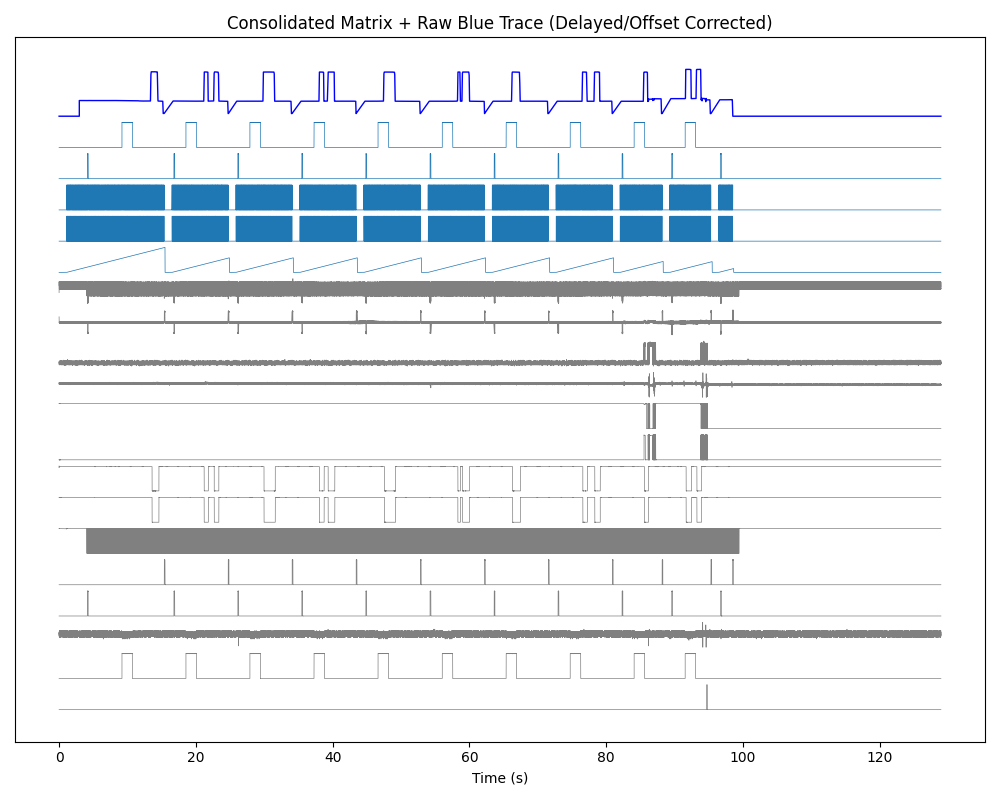

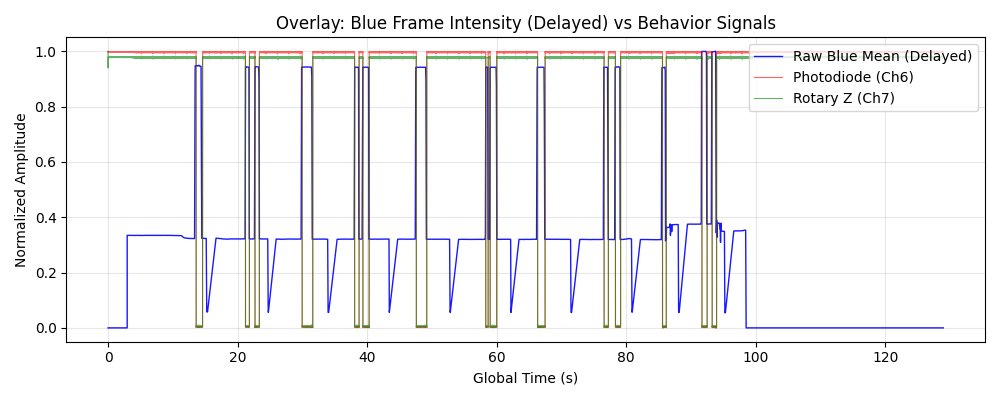

In [15]:
# --- Step 6: Refined Frame Synchronization and Raw Blue Trace (With Offset) ---
# This step aligns captured frames to the global timeline by matching frame indices to Analog TTLs.
# We incorporate an OFFSET (PreStim/Baseline frames) found in frameTimes.mat.
# CORRECTED LOGIC: "preStim" represents a DELAY. We Adding frames/delaying start.
# Implementation: Keep All Frames (Start Frame 0). Align Frame 0 to TTL[Offset].


try:
    %matplotlib widget
    print("Interactive plotting enabled (ipympl).")
except:
    print("Warning: Could not enable interactive plotting. Using default backend.")

import matplotlib.pyplot as plt
import numpy as np

# Helper function to check frame intensity
def check_blue_is_first_via_intensity_local(dat_file_path, H, W, dtype=np.uint16):
    try:
        pixels_per_frame = H * W
        bytes_per_pixel = np.dtype(dtype).itemsize
        bytes_to_read = 2 * pixels_per_frame * bytes_per_pixel
        
        with open(dat_file_path, 'rb') as f:
            data_bytes = f.read(bytes_to_read)
            
        if len(data_bytes) < bytes_to_read: return True
        data = np.frombuffer(data_bytes, dtype=dtype)
        if len(data) < pixels_per_frame * 2: return True

        m0 = np.mean(data[:pixels_per_frame])
        m1 = np.mean(data[pixels_per_frame:])
        
        # Violet (Hemo) is usually brighter (higher values) than Blue (Functional)
        return m0 < m1
    except:
        return True

# Storage for the continuous Blue trace
global_blue_times = []
global_blue_vals = []

# Find frameTimes files
ft_files = sorted(glob.glob(os.path.join(data_dir, "*frameTimes*.mat")))

if 'analog_trials' in locals() and 'trials_hdf5' in locals() and len(frames_files) > 0:
    print("Starting refined synchronization with PreStim offset...")
    print("VERIFICATION OF OFFSET LOGIC (CORRECTED):")
    print("We interpret 'preStim' frame count as a START DELAY.")
    print("Action: Keep ALL Frames. Align Frame 0 to TTL[Offset].")
    print("Result: Frames are shifted Rightwards (Later in Time).")
    print("---------------------------------------------------------------")
    
    n_proc = min(len(analog_trials), len(frames_files))
    
    for i in range(n_proc):
        try:
            # Load Trial Metadata
            a_trial = analog_trials[i]
            h_trial = trials_hdf5[i]
            f_path = frames_files[i]
            
            # --- LOAD OFFSET FROM MAT FILE ---
            # Assume strict naming correspondence 1-to-1 or use list
            offset_frames = 0
            if i < len(ft_files):
                try:
                    import scipy.io
                    ft_mat = scipy.io.loadmat(ft_files[i])
                    # Logic: Use removedFrames if > 0, else use preStim
                    removed_val = 0
                    if 'removedFrames' in ft_mat:
                        removed_val = int(ft_mat['removedFrames'].flatten()[0])
                        
                    if removed_val > 0:
                        offset_frames = removed_val
                        print(f"  Source: removedFrames ({offset_frames})")
                    elif 'preStim' in ft_mat:
                        offset_frames = int(ft_mat['preStim'].flatten()[0])
                        print(f"  Source: preStim ({offset_frames})")
                    
                    # Calculate and Print Verification Stats
                    offset_time_s = offset_frames * (1.0 / 20.0)
                    print(f"Trial {i} Offset:")
                    print(f"  Final Offset Frames: {offset_frames}")
                    print(f"  Effective Delay: {offset_frames} pulses ~ {offset_time_s:.2f} seconds")
                    print(f"  Mapping: Frame 0 -> TTL {offset_frames}")
                    
                except Exception as e:
                    print(f"  Trial {i}: Could not load frameTimes.mat: {e}")
            
            # Determine Frame Dimensions
            channels, h_dim, w_dim = 2, 640, 540
            parts = os.path.basename(f_path).split('_')
            nums = [int(p) for p in parts if p.isdigit()]
            if len(nums) >= 3: channels, h_dim, w_dim = nums[:3]
                
            # 1. Determine Frame Sequence Colors
            is_blue_first = check_blue_is_first_via_intensity_local(f_path, h_dim, w_dim)
            if not is_blue_first:
                print(f"  Trial {i}: Detected Violet First (swapped sequence).")
            
            # 2. Get All TTLs from Analog (Ch1=Blue, Ch2=Violet)
            raw_ch1 = a_trial['data'][1].astype(float)
            raw_ch2 = a_trial['data'][2].astype(float)
            
            # Find rising edges using threshold (normalized locally)
            r_blue, _ = find_edges(normalize_arr(raw_ch1), 0.5)
            r_violet, _ = find_edges(normalize_arr(raw_ch2), 0.5)
            
            # Create a sorted list of all TTL events: (sample_index, type)
            ttls = [(t, 'blue') for t in r_blue] + [(t, 'violet') for t in r_violet]
            ttls.sort(key=lambda x: x[0])
            
            if not ttls:
                print(f"  Trial {i}: No TTLs found. Skipping.")
                continue
            
            # Verify we have enough TTLs to support the offset
            if offset_frames >= len(ttls):
                print(f"  Trial {i}: Offset {offset_frames} >= Total TTLs {len(ttls)}. Impossible to sync.")
                continue

            # 3. Load All Frames (We keep them all now)
            with open(f_path, 'rb') as f:
                raw_dat = np.fromfile(f, dtype='uint16')
            
            n_pix = h_dim * w_dim 
            n_total_frames = len(raw_dat) // n_pix
            
            # 4. Sync Logic: Match Frame[0] -> TTL[Offset]
            ttl_idx = offset_frames # Skip this many pulses
            frame_idx = 0           # Start at Frame 0
            
            # Check color consistency at the alignment point
            # Frame 0 color depends on is_blue_first.
            frame0_color = 'blue' if is_blue_first else 'violet'
            
            # TTL at offset color
            ttl_offset_color = ttls[ttl_idx][1]
            
            if frame0_color != ttl_offset_color:
                print(f"  Trial {i} Sync Logic Check: Frame[0] is {frame0_color}, TTL[{ttl_idx}] is {ttl_offset_color}.")
                # Adjust TTL index to find match (Delay slightly more)
                ttl_idx += 1
                if ttl_idx < len(ttls):
                    print(f"  -> Adjustment: Skipped 1 extra TTL. New Start TTL: {ttl_idx} ({ttls[ttl_idx][1]})")
                else:
                     print("  -> Failed to find matching TTL.")
                     continue
            
            # 5. Extract Data
            t_trig_glob = h_trial['start_time_s']
            t_trig_loc_s = a_trial['local_start_sample'] / 1000.0
            t_start_glob = t_trig_glob - t_trig_loc_s 
            
            trial_times = []
            trial_vals = []
            
            # Iterate through matched pairs
            while frame_idx < n_total_frames and ttl_idx < len(ttls):
                
                # Determine color of current frame
                # Frame sequence is deterministic from Frame 0
                frame_is_blue = (frame0_color == 'blue' and frame_idx % 2 == 0) or \
                                (frame0_color == 'violet' and frame_idx % 2 != 0)
                
                # We only want to plot the Blue Frames
                if frame_is_blue:
                    # Index in raw_dat
                    start_ptr = frame_idx * n_pix
                    end_ptr = start_ptr + n_pix
                    frame_pixels = raw_dat[start_ptr:end_ptr]
                    
                    val = np.mean(frame_pixels)
                    
                    # Time from TTL
                    ttl_sample = ttls[ttl_idx][0]
                    t_glob = t_start_glob + (ttl_sample / 1000.0)
                    
                    trial_times.append(t_glob)
                    trial_vals.append(val)
                
                frame_idx += 1
                ttl_idx += 1

            print(f"  Extracted {len(trial_vals)} Blue Frames.")
            
            # --- Auto-Correction for "Early Drop" ---
            # Inspect the gap between the last Blue Frame and the Trial Stop
            if len(trial_times) > 0:
                last_frame_t = trial_times[-1]
                t_stop_glob = h_trial['start_time_s'] + (h_trial['stop_sample'] - h_trial['start_sample']) / 10000.0
                gap = t_stop_glob - last_frame_t
                
                # Check directly if gap is positive (Blue ends early)
                if gap > 0 and gap < 5.0: # Reasonable bounds
                    pass # We will collect this
                else: 
                     # If gap is negative (Blue extends past stop), it's also a valid offset (negative delay)
                     pass
                     
                print(f"  Trial {i} Gap analysis: Stop={t_stop_glob:.3f} | LastFrame={last_frame_t:.3f} | Diff={gap:.4f}s")
                
                # Store gap for global correction
                # We can either correct per-trial or globally. 
                # User asked for "a secondary offset", implying global.
                # But we can store it here.
                a_trial['calculated_gap'] = gap

            global_blue_times.extend(trial_times)
            global_blue_vals.extend(trial_vals)
            
        except Exception as e:
            print(f"Error processing trial {i}: {e}")
            import traceback
            traceback.print_exc()

    # --- Calculate and Apply Secondary Offset ---
    gaps = [t.get('calculated_gap', np.nan) for t in analog_trials if 'calculated_gap' in t]
    valid_gaps = [g for g in gaps if not np.isnan(g) and abs(g) < 2.0]
    
    if valid_gaps:
        secondary_offset = np.mean(valid_gaps)
        print(f"\n--- Secondary Offset Correction ---")
        print(f"Calculated Mean Gap (Trial Stop - Last Frame): {secondary_offset:.4f} s")
        print(f"Applying this shift to ALL Blue Frames...")
        
        # Apply shift
        global_blue_times = [t + secondary_offset for t in global_blue_times]
    else:
        print("\n--- Secondary Offset Correction ---")
        print("Could not calculate valid gaps. No shift applied.")

    # 6. Interpolate to Global Matrix Time (10kHz) & Normalize
    print("Interpolating to global timeline...")
    
    # Sort points
    srt = np.argsort(global_blue_times)
    t_source = np.array(global_blue_times)[srt]
    v_source = np.array(global_blue_vals)[srt]
    
    # Target time: indices of full_matrix
    n_samples = full_matrix.shape[0]
    t_target = np.arange(n_samples) / 10000.0
    
    # Interpolate
    blue_trace = np.interp(t_target, t_source, v_source, left=0, right=0)
    
    # Normalize 0-1
    b_min, b_max = np.min(blue_trace), np.max(blue_trace)
    if b_max > b_min:
        blue_trace_norm = (blue_trace - b_min) / (b_max - b_min)
    else:
        blue_trace_norm = blue_trace
        
    print("Raw Blue Trace Prepared (Start Delayed / Offset Corrected).")
    
    # --- PLOT 1: Mega Matrix with Raw Blue ---
    plt.figure(figsize=(10, 8)) # Adjusted size for interactive window
    t_glob = t_target
    
    # HDF5
    for i in range(14):
        sig = normalize_arr(full_matrix[:, i]) * 0.8
        plt.plot(t_glob, sig + i, color='grey', linewidth=0.5)
        # Text labels might clutter interactive plots if not careful, but okay here
        # plt.text(t_glob[0], i, channel_map.get(i, str(i)), fontsize=8) 

    # Analog
    for i in range(5):
        row = 14 + i
        sig = normalize_arr(full_matrix[:, row]) * 0.8
        plt.plot(t_glob, sig + row, color='tab:blue', linewidth=0.5)
        
    # Raw Blue
    row_blue = 19
    plt.plot(t_glob, blue_trace_norm * 1.5 + row_blue, color='blue', linewidth=1)
    
    plt.yticks([])
    plt.xlabel('Time (s)')
    plt.title('Consolidated Matrix + Raw Blue Trace (Delayed/Offset Corrected)')
    plt.tight_layout()
    plt.show()
    
    
    # --- PLOT 2: Overlay Plot (Blue + Ch6 + Ch7) ---
    plt.figure(figsize=(10, 4)) # Adjusted size for interactive window
    
    # Plot Raw Blue (Background/Reference)
    plt.plot(t_glob, blue_trace_norm, color='blue', alpha=0.9, label='Raw Blue Mean (Delayed)', linewidth=1)
    
    # Overlay Ch6 (Photodiode)
    ch6 = normalize_arr(full_matrix[:, 6])
    plt.plot(t_glob, ch6, color='red', alpha=0.6, label='Photodiode (Ch6)', linewidth=0.8)
    
    # Overlay Ch7 (Rotary Z)
    ch7 = normalize_arr(full_matrix[:, 7])
    plt.plot(t_glob, ch7, color='green', alpha=0.6, label='Rotary Z (Ch7)', linewidth=0.8)
    
    plt.title("Overlay: Blue Frame Intensity (Delayed) vs Behavior Signals")
    plt.xlabel("Global Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("Cannot run verification: Prerequisites not found. Please re-run previous cells to load data.")


In [16]:
# --- Investigation: Finding Offset Metadata ---
# User mentions a text file (likely ledTTL...) containing 'baseline frames' equal to 40 (Trial 1) and 4 (Trial 2).
# We search for this file and also check frameTimes.mat for this info.

import scipy.io

print("--- Inspecting PreStim in FrameTimes.mat ---")
ft_files = sorted(glob.glob(os.path.join(data_dir, "*frameTimes*.mat")))
if ft_files:
    for i in range(min(5, len(ft_files))):
        ft_path = ft_files[i]
        try:
            ft_data = scipy.io.loadmat(ft_path)
            
            pre_stim = ft_data.get('preStim', [[-1]])[0][0]
            removed = ft_data.get('removedFrames', [[-1]])[0][0]
            
            print(f"{os.path.basename(ft_path)}: preStim={pre_stim}, removedFrames={removed}")
            
        except Exception as e:
            print(f"Error loading {os.path.basename(ft_path)}: {e}")
else:
    print("No frameTimes.mat found.")

--- Inspecting PreStim in FrameTimes.mat ---
frameTimes_0001.mat: preStim=40, removedFrames=74
frameTimes_0002.mat: preStim=4, removedFrames=0
frameTimes_0003.mat: preStim=3, removedFrames=0
frameTimes_0004.mat: preStim=4, removedFrames=0
frameTimes_0005.mat: preStim=3, removedFrames=0


In [17]:
# --- Investigation Step: Check for Buffer/Baseline Frames in Metadata and Logs ---
import os
import glob
import scipy.io

print("--- Searching for Text/Log Files ---")
txt_files = glob.glob(os.path.join(data_dir, "*.txt")) + glob.glob(os.path.join(data_dir, "*.log"))
for f in txt_files:
    print(f"Reading: {os.path.basename(f)}")
    try:
        with open(f, 'r') as fd:
            content = fd.readlines()
            # Print first 10 lines and lines containing "buffer" or "frames"
            for i, line in enumerate(content):
                if i < 10 or "buffer" in line.lower() or "frames" in line.lower():
                    print(f"  L{i}: {line.strip()}")
    except Exception as e:
        print(f"  Error reading {f}: {e}")

print("\n--- Inspecting frameTimes.mat for Buffer/Baseline Info ---")
ft_files = glob.glob(os.path.join(data_dir, "*frameTimes*.mat"))
if ft_files:
    try:
        ft_data = scipy.io.loadmat(ft_files[0])
        print("Keys in frameTimes.mat:", ft_data.keys())
        
        # Check specific keys that might relate to baseline/buffer
        for key in ft_data.keys():
            if key.startswith('__'): continue
            val = ft_data[key]
            # Print summary of the value
            if isinstance(val, (np.ndarray, list)):
                print(f"{key}: Shape {np.shape(val)}")
                if np.size(val) < 20:
                    print(f"  Values: {val}")
                elif np.size(val) > 0:
                    # If 1D or 2D, print first few
                    flat = np.ravel(val)
                    print(f"  First 5 values: {flat[:5]}")
            else:
                print(f"{key}: {val}")
                
        # Specifically check preStim if it exists
        if 'preStim' in ft_data:
            print(f"\nExplicit check of 'preStim': {ft_data['preStim']}")
            
    except Exception as e:
        print(f"Error inspecting mat file: {e}")
else:
    print("No frameTimes.mat found.")

--- Searching for Text/Log Files ---
Reading: eyecam_Vtest_ledTTL_OlfactometerMultipleOdorsProtocol_202601231521158.txt
  L0: 1769199681.3980
  L1: 1769199681.4021
  L2: 1769199681.4380
  L3: 1769199681.4885
  L4: 1769199681.5376
  L5: 1769199681.5884
  L6: 1769199681.6379
  L7: 1769199681.6882
  L8: 1769199681.7377
  L9: 1769199681.7881
Reading: ledTTL_random.txt
  L0: Vane controlling led at random times.
  L1: 10 trials.
  L2: 1 led flash every odd number trial
  L3: 2 flashes on even number trials
  L4: 
  L5: First 8 trials maxed out (no engagement/spins). Last 2 trials i spinned.
  L6: Trial 9 = right spin (wrong choice)
  L7: Trial 10 = left spin (success)
  L8: 
  L9: Ignore Trial 1 (wdf records after end for a few seconds, idk why)
  L22: Waiting... Removing 40 frames from buffer
  L23: Received stop trigger. Stopped after 449 poststim frames
  L24: Trial finished... Removing 34 frames from buffer
  L25: Trial 1; Baseline Frames: 40; Poststim Frames: 459; Dark Frames: 5; Savin

In [18]:
import scipy.io
import glob
import os
import numpy as np

# Find all frameTimes files
all_ft_files = glob.glob(os.path.join(data_dir, "*frameTimes*.mat"))
all_ft_files.sort()

print(f"Found {len(all_ft_files)} frameTimes.mat files.\n")

for ft_file in all_ft_files:
    try:
        mat_data = scipy.io.loadmat(ft_file)
        fname = os.path.basename(ft_file)
        print(f"\n{fname}:")
        print("-" * 60)
        for key in mat_data:
            if key.startswith('__'):
                continue
            val = mat_data[key]
            if isinstance(val, np.ndarray):
                print(f"  {key}: shape={val.shape}, dtype={val.dtype}")
                # Print small arrays or first few values for larger arrays
                if val.size <= 10:
                    print(f"    values: {val}")
                else:
                    flat = val.ravel()
                    print(f"    first 5 values: {flat[:5]}")
            else:
                print(f"  {key}: {val}")
    except Exception as e:
        print(f"{os.path.basename(ft_file)} | Error: {e}")


Found 11 frameTimes.mat files.


frameTimes_0001.mat:
------------------------------------------------------------
  removedFrames: shape=(1, 1), dtype=uint8
    values: [[74]]
  frameTimes: shape=(499, 1), dtype=float64
    first 5 values: [740005.63981763 740005.63981791 740005.6398182  740005.63981849
 740005.63981878]
  preStim: shape=(1, 1), dtype=uint8
    values: [[40]]
  postStim: shape=(1, 1), dtype=uint16
    values: [[459]]
  imgSize: shape=(1, 4), dtype=uint16
    values: [[540 640   1 499]]

frameTimes_0002.mat:
------------------------------------------------------------
  removedFrames: shape=(1, 1), dtype=uint8
    values: [[0]]
  frameTimes: shape=(331, 1), dtype=float64
    first 5 values: [740005.63997444 740005.63997473 740005.63997502 740005.63997531
 740005.6399756 ]
  preStim: shape=(1, 1), dtype=uint8
    values: [[4]]
  postStim: shape=(1, 1), dtype=uint16
    values: [[327]]
  imgSize: shape=(1, 4), dtype=uint16
    values: [[540 640   1 331]]

frameTimes_0003

In [19]:
# --- Investigation Step: Calculate Difference between Blue Drops and Trial Stops ---

if 't_target' in locals() and 'blue_trace_norm' in locals() and 'trials_hdf5' in locals():
    print("--- Analyzing Timing Differences (Early Drop vs Trial Stop) ---")
    
    delays = []
    
    # Analyze first n trials
    for i, h_trial in enumerate(trials_hdf5[:15]):
        # HDF5 defined Stop Time
        stop_sample = h_trial['stop_sample']
        start_sample = h_trial['start_sample']
        t_start_global = h_trial['start_time_s']
        # Stop time in global seconds
        t_stop_global = t_start_global + (stop_sample - start_sample) / 10000.0
        
        # Find where Blue Trace Drops near this stop time
        # Look in a window around t_stop_global (e.g. -2s to +0.5s)
        window_mask = (t_target > t_stop_global - 5.0) & (t_target < t_stop_global + 1.0)
        
        if np.sum(window_mask) > 0:
            t_window = t_target[window_mask]
            v_window = blue_trace_norm[window_mask]
            
            # Find the index of the "Drop"
            # It goes from High (~1.0) to Low (~0.0). 
            # We look for the last point where value > 0.1 (assuming signal drops to near 0)
            threshold = 0.1
            high_indices = np.where(v_window > threshold)[0]
            
            if len(high_indices) > 0:
                last_high_idx = high_indices[-1]
                t_last_high = t_window[last_high_idx]
                
                # Difference: Stop Time - Last Frame Time
                # If Drop is BEFORE Stop, t_last_high < t_stop_global, diff is Positive.
                diff = t_stop_global - t_last_high
                
                print(f"Trial {i}: Stop={t_stop_global:.3f}s | Drop={t_last_high:.3f}s | Diff={diff:.4f}s")
                if diff > -1.0 and diff < 2.0: # Filter outliers
                    delays.append(diff)
            else:
                 print(f"Trial {i}: No signal > {threshold} found in window.")
        else:
            print(f"Trial {i}: Window out of bounds.")
            
    if len(delays) > 0:
        mean_delay = np.mean(delays)
        print(f"\nAverage Gap/Lag: {mean_delay:.4f} s")
        print(f"Equivalent to ~{mean_delay * 20:.2f} frames (@20Hz)")
        
        # Define secondary offset for next steps
        SECONDARY_OFFSET_S = mean_delay
    else:
        print("Could not calculate average delay.")
        SECONDARY_OFFSET_S = 0.0
else:
    print("Data not ready for analysis.")

--- Analyzing Timing Differences (Early Drop vs Trial Stop) ---
Trial 0: Stop=15.381s | Drop=16.381s | Diff=-0.9999s
Trial 1: Stop=24.732s | Drop=25.732s | Diff=-0.9999s
Trial 2: Stop=34.087s | Drop=35.087s | Diff=-0.9999s
Trial 3: Stop=43.451s | Drop=44.451s | Diff=-0.9999s
Trial 4: Stop=52.841s | Drop=53.841s | Diff=-1.0000s
Trial 5: Stop=62.215s | Drop=63.215s | Diff=-0.9999s
Trial 6: Stop=71.558s | Drop=72.558s | Diff=-0.9999s
Trial 7: Stop=80.920s | Drop=81.920s | Diff=-0.9999s
Trial 8: Stop=88.189s | Drop=89.188s | Diff=-0.9999s
Trial 9: Stop=95.323s | Drop=96.323s | Diff=-0.9999s
Trial 10: Stop=98.507s | Drop=98.499s | Diff=0.0082s

Average Gap/Lag: -0.9083 s
Equivalent to ~-18.17 frames (@20Hz)


In [29]:
import numpy as np

# Load the aligned matrix from the output directory
matrix_path =r"D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\alignment\aligned_full_matrix.npy"

loaded_matrix = np.load(matrix_path)

print(f"Loaded matrix from: {matrix_path}")
print(f"Matrix shape: {loaded_matrix.shape}")
print(f"Matrix dtype: {loaded_matrix.dtype}")
print(f"\nMatrix summary:")
print(f"  Number of samples: {loaded_matrix.shape[0]} ({loaded_matrix.shape[0]/10000:.2f} seconds at 10kHz)")
print(f"  Number of channels: {loaded_matrix.shape[1]}")
print(f"    - HDF5 channels: 0-13")
print(f"    - Analog channels: 14-18")
print(f"    - Corrected frames: 19")

Loaded matrix from: D:\Vanessa_test_data\Tests_Jan23\23-Jan-2026_ledTTL_10random\alignment\aligned_full_matrix.npy
Matrix shape: (1289654, 22)
Matrix dtype: float32

Matrix summary:
  Number of samples: 1289654 (128.97 seconds at 10kHz)
  Number of channels: 22
    - HDF5 channels: 0-13
    - Analog channels: 14-18
    - Corrected frames: 19


In [21]:
# Find trial stop events using HDF5 Channel 4 (Stop Signal)
stop_signal = loaded_matrix[:, 4]

# Find rising and falling edges
stop_rising_edges, stop_falling_edges = find_edges(normalize_arr(stop_signal), threshold=0.5)

# Convert sample indices to time (seconds)
stop_times = stop_rising_edges / 10000.0
stop_falling_times = stop_falling_edges / 10000.0

print(f"Found {len(stop_rising_edges)} trial stop events (rising edges)")
print(f"Found {len(stop_falling_edges)} trial stop events (falling edges)")

print(f"\nStop rising times (seconds):")
for i, (sample, time) in enumerate(zip(stop_rising_edges, stop_times)):
    print(f"  Stop {i}: Sample {sample} | Time {time:.4f} s")

print(f"\nStop falling times (seconds):")
for i, (sample, time) in enumerate(zip(stop_falling_edges, stop_falling_times)):
    print(f"  Stop {i}: Sample {sample} | Time {time:.4f} s")

Found 11 trial stop events (rising edges)
Found 11 trial stop events (falling edges)

Stop rising times (seconds):
  Stop 0: Sample 153807 | Time 15.3807 s
  Stop 1: Sample 247325 | Time 24.7325 s
  Stop 2: Sample 340875 | Time 34.0875 s
  Stop 3: Sample 434508 | Time 43.4508 s
  Stop 4: Sample 528413 | Time 52.8413 s
  Stop 5: Sample 622146 | Time 62.2146 s
  Stop 6: Sample 715582 | Time 71.5582 s
  Stop 7: Sample 809202 | Time 80.9202 s
  Stop 8: Sample 881885 | Time 88.1885 s
  Stop 9: Sample 953235 | Time 95.3235 s
  Stop 10: Sample 985074 | Time 98.5074 s

Stop falling times (seconds):
  Stop 0: Sample 154838 | Time 15.4838 s
  Stop 1: Sample 248355 | Time 24.8355 s
  Stop 2: Sample 341900 | Time 34.1900 s
  Stop 3: Sample 435550 | Time 43.5550 s
  Stop 4: Sample 529443 | Time 52.9443 s
  Stop 5: Sample 623182 | Time 62.3182 s
  Stop 6: Sample 716624 | Time 71.6624 s
  Stop 7: Sample 810240 | Time 81.0240 s
  Stop 8: Sample 882918 | Time 88.2918 s
  Stop 9: Sample 954277 | Time 95

In [22]:
from scipy.signal import argrelextrema

# Find local minima in stimulus trace near stop events
# Using widefield raw stimulus channel (Index 19)

stimulus_trace = loaded_matrix[:, 19]

# Storage for stop events and their corresponding minima
stop_minima_analysis = []

print("Finding local minima near stop events (using falling edges):")
print("-" * 80)

# Use falling edges instead of rising edges
for i, (stop_sample, stop_time) in enumerate(zip(stop_falling_edges, stop_falling_times)):
    # Define search window: backward from stop event
    window_samples = int(5.0 * 10000)  # 5 seconds at 10kHz
    
    start_idx = stop_sample - window_samples
    end_idx = stop_sample
    
    # Ensure valid bounds
    if start_idx < 0:
        start_idx = 0
    
    # Extract window (searching backward from stop)
    window_trace = stimulus_trace[start_idx:end_idx]
    # Normalize the window_trace before finding the minimum
    if np.nanmax(window_trace) > np.nanmin(window_trace):
        window_trace = (window_trace - np.nanmin(window_trace)) / (np.nanmax(window_trace) - np.nanmin(window_trace))
    window_indices = np.arange(start_idx, end_idx)
    
    # Find minimum by moving rightward (forward in time toward stop)
    # Strategy: the first local minimum we encounter is our target
    min_value = float('inf')
    min_sample = None
    
    for idx in range(len(window_trace)):
        current_val = window_trace[idx]
        
        # Update if we found a smaller value
        if current_val < min_value:
            min_value = current_val
            min_sample = window_indices[idx]
    
    if min_sample is not None:
        closest_min_time = min_sample / 10000.0
        time_diff = (min_sample - stop_sample) / 10000.0
        
        stop_minima_analysis.append({
            'stop_idx': i,
            'stop_sample': stop_sample,
            'stop_time': stop_time,
            'min_sample': min_sample,
            'min_time': closest_min_time,
            'min_value': min_value,
            'time_diff': time_diff
        })
        
        print(f"Stop {i}:")
        print(f"  Stop Time: {stop_time:.4f} s (Sample {stop_sample})")
        print(f"  Minimum: {closest_min_time:.4f} s (Sample {min_sample})")
        print(f"  Time Difference: {time_diff:.4f} s ({time_diff*1000:.1f} ms)")
        print(f"  Min Value: {min_value:.6f}")
    else:
        print(f"Stop {i}: No minimum found in window")
        
print("\n" + "=" * 80)
print(f"Summary: Found {len(stop_minima_analysis)} stop-minima pairs")

Finding local minima near stop events (using falling edges):
--------------------------------------------------------------------------------
Stop 0:
  Stop Time: 15.4838 s (Sample 154838)
  Minimum: 12.8352 s (Sample 128352)
  Time Difference: -2.6486 s (-2648.6 ms)
  Min Value: 0.000000
Stop 1:
  Stop Time: 24.8355 s (Sample 248355)
  Minimum: 24.8354 s (Sample 248354)
  Time Difference: -0.0001 s (-0.1 ms)
  Min Value: 0.000000
Stop 2:
  Stop Time: 34.1900 s (Sample 341900)
  Minimum: 34.1899 s (Sample 341899)
  Time Difference: -0.0001 s (-0.1 ms)
  Min Value: 0.000000
Stop 3:
  Stop Time: 43.5550 s (Sample 435550)
  Minimum: 38.9316 s (Sample 389316)
  Time Difference: -4.6234 s (-4623.4 ms)
  Min Value: 0.000000
Stop 4:
  Stop Time: 52.9443 s (Sample 529443)
  Minimum: 52.9442 s (Sample 529442)
  Time Difference: -0.0001 s (-0.1 ms)
  Min Value: 0.000000
Stop 5:
  Stop Time: 62.3182 s (Sample 623182)
  Minimum: 57.8928 s (Sample 578928)
  Time Difference: -4.4254 s (-4425.4 ms)
 

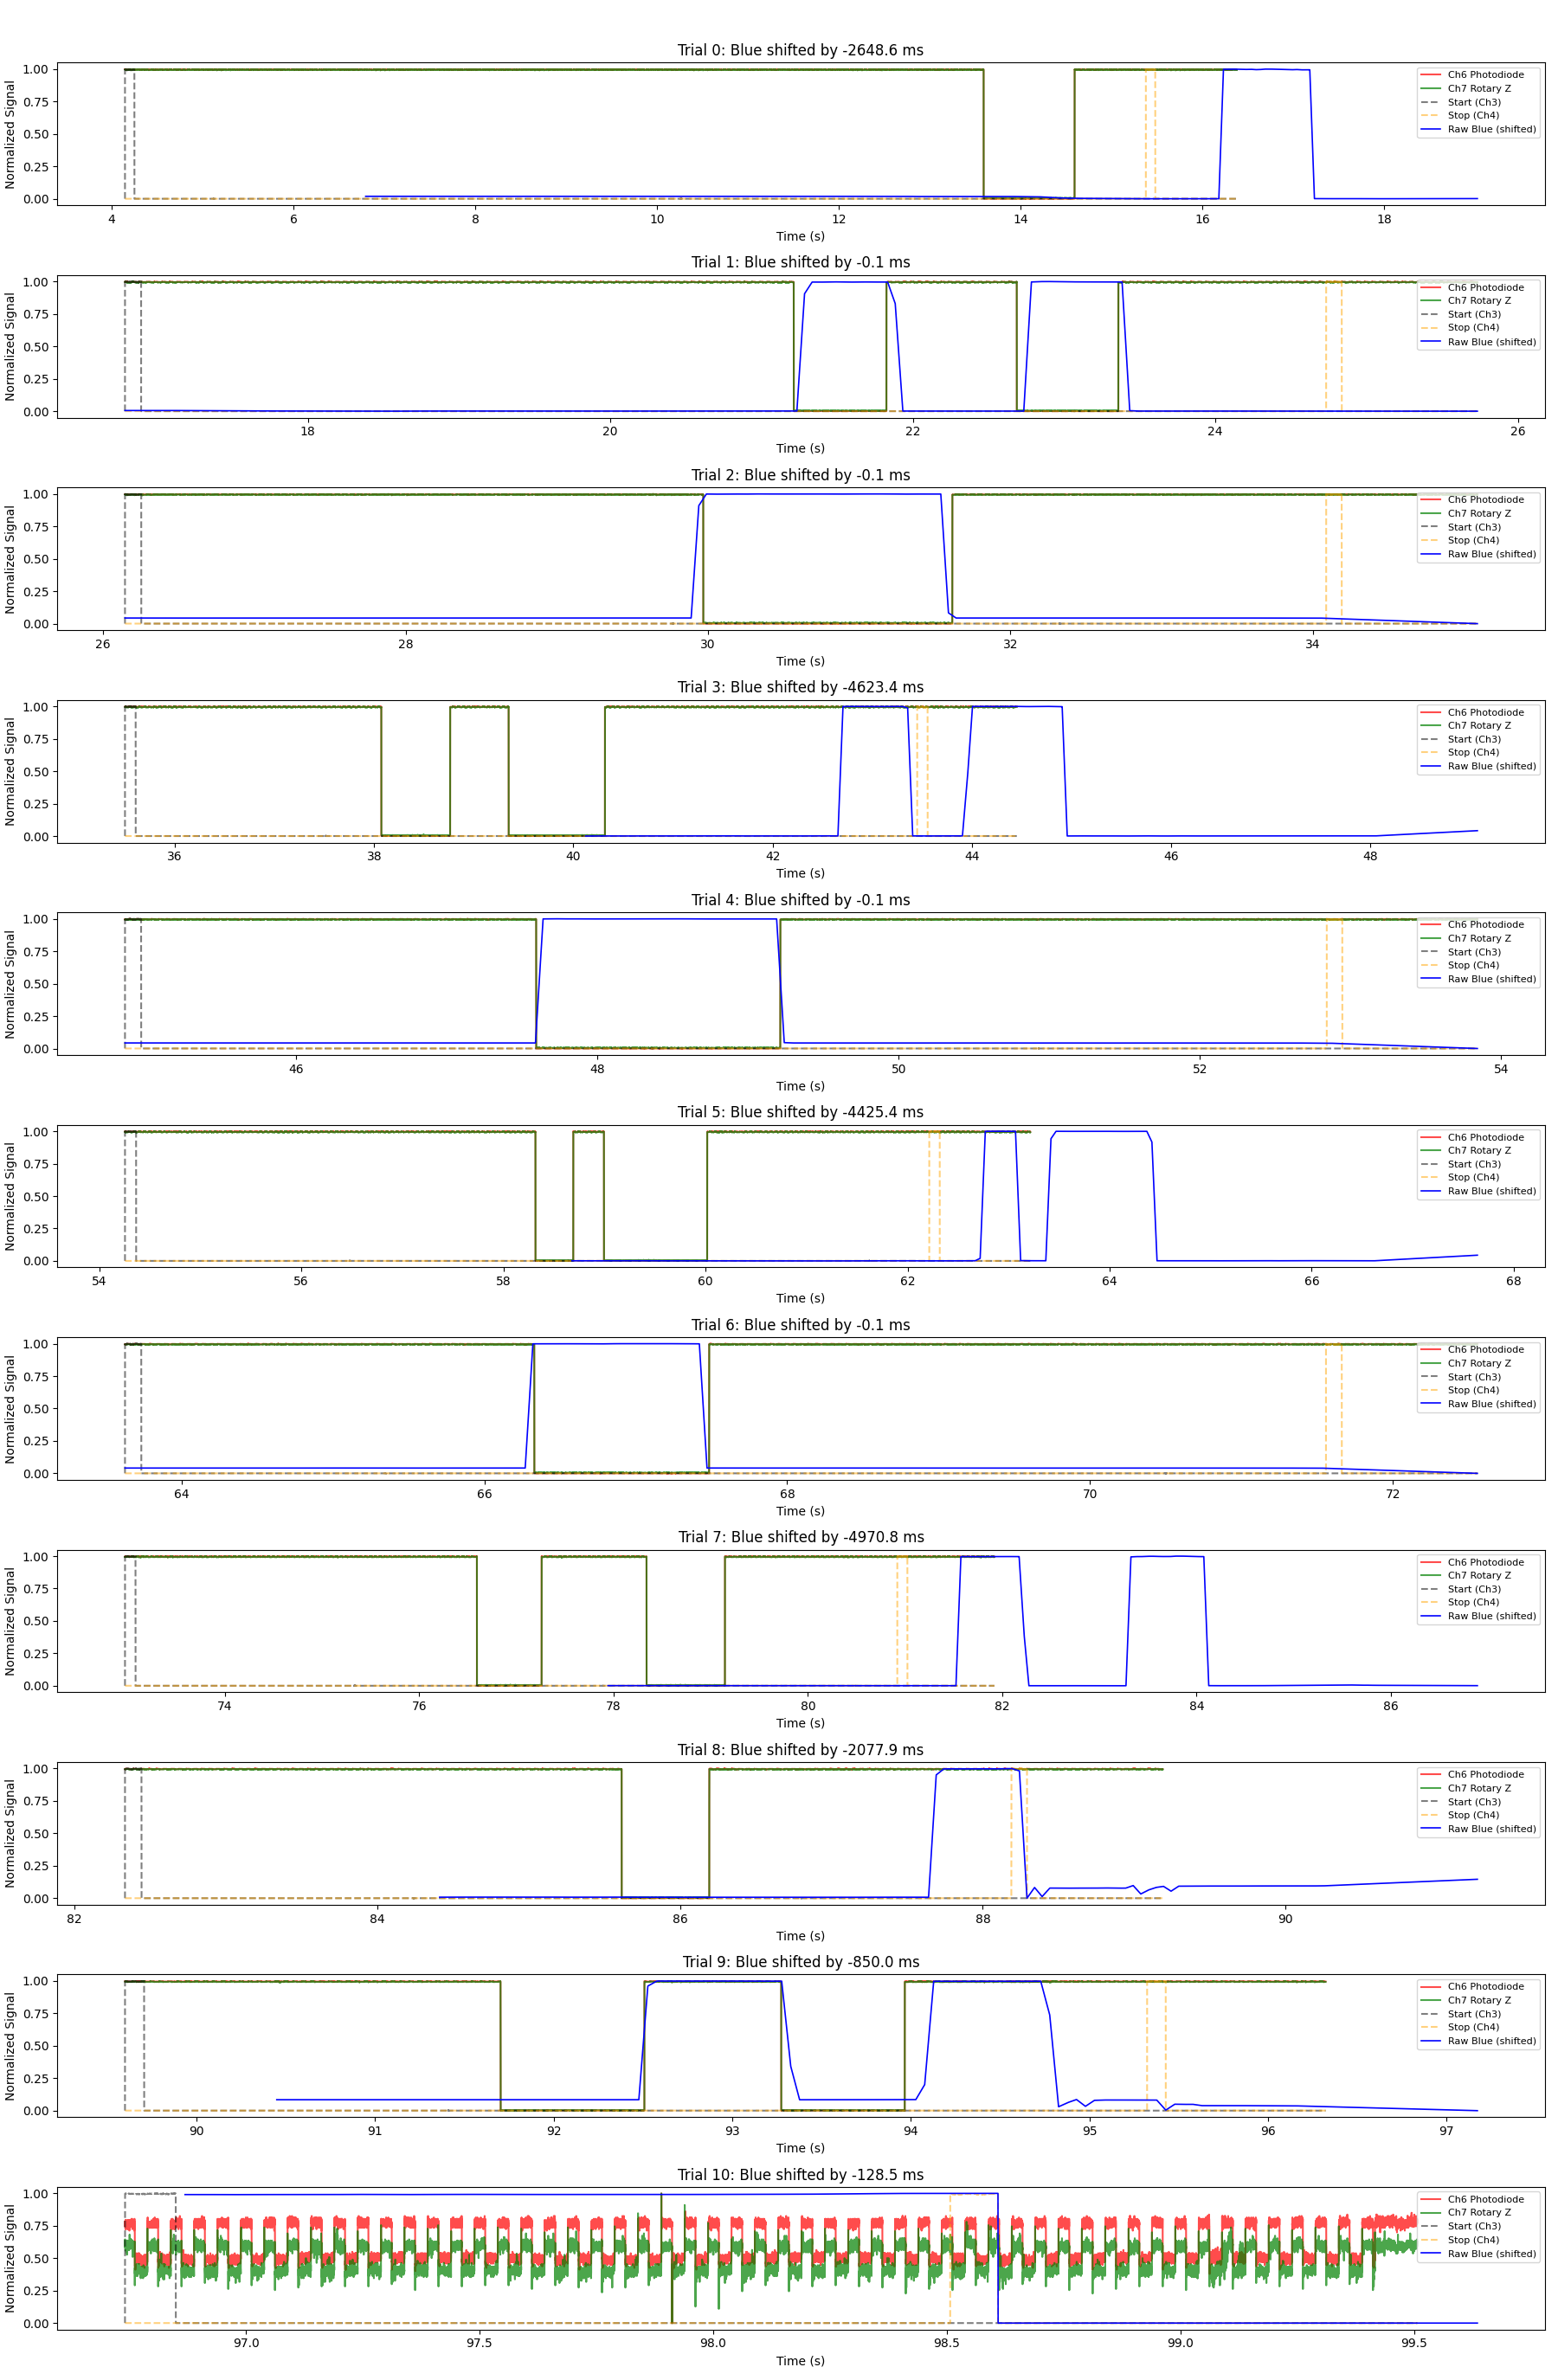

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Use stop_minima_analysis for per-trial time shifts
# We'll shift the blue trace for each trial by the corresponding time_diff (rightwards)

# Channel indices
ch6 = 6  # Photodiode
ch7 = 7  # Rotary Z
ch_start = 3  # Acquisition Start
ch_stop = 4   # Stop Signal
ch_blue = 19  # Raw average blue trace

# Prepare for plotting
n_trials = len(stop_minima_analysis)
t_global = np.arange(loaded_matrix.shape[0]) / 10000.0

plt.figure(figsize=(18, 2.5 * n_trials))
for i, trial in enumerate(stop_minima_analysis):
    # Get trial start/stop in samples
    trial_start = trials_hdf5[i]['start_sample']
    trial_stop = trials_hdf5[i]['stop_sample']
    t_start = trial['stop_time'] - (trial_stop - trial_start) / 10000.0
    t_stop = trial['stop_time']
    shift = trial['time_diff']  # negative, so shifting rightwards

    # Extract trial window
    idx_start = trial_start
    idx_stop = trial_stop + 10000
    t_trial = t_global[idx_start:idx_stop] + abs(shift)  # shift rightwards

    # Normalize each channel in the window
    def norm(x):
        x = np.asarray(x)
        min_v = np.nanmin(x)
        max_v = np.nanmax(x)
        return (x - min_v) / (max_v - min_v) if max_v > min_v else x

    # Plot
    ax = plt.subplot(n_trials, 1, i + 1)
    # Channel 6
    plt.plot(t_global[idx_start:idx_stop], norm(loaded_matrix[idx_start:idx_stop, ch6]), label='Ch6 Photodiode', color='red', alpha=0.7)
    # Channel 7
    plt.plot(t_global[idx_start:idx_stop], norm(loaded_matrix[idx_start:idx_stop, ch7]), label='Ch7 Rotary Z', color='green', alpha=0.7)
    # Start signal
    plt.plot(t_global[idx_start:idx_stop], norm(loaded_matrix[idx_start:idx_stop, ch_start]), label='Start (Ch3)', color='black', linestyle='--', alpha=0.5)
    # Stop signal
    plt.plot(t_global[idx_start:idx_stop], norm(loaded_matrix[idx_start:idx_stop, ch_stop]), label='Stop (Ch4)', color='orange', linestyle='--', alpha=0.5)
    # Raw blue trace (shifted)
    blue_trace = loaded_matrix[idx_start:idx_stop, ch_blue]
    plt.plot(t_trial, norm(blue_trace), label='Raw Blue (shifted)', color='blue', linewidth=1.2)

    plt.title(f"Trial {i}: Blue shifted by {shift*1000:.1f} ms")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Signal")
    plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()

plt.suptitle("Per-Trial: Ch6, Ch7, Start, Stop, and Shifted Raw Blue Trace", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()